In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize,compute_confution_matrix
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset , ValidUnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.99,
    "weight_decay" : 3e-5,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"tversky loss",
    "alpha":0.3,
    "beta":0.7,
    "t_gamma":2.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-DSV-tev",
    "deep_super_vision" : True,
    "f_alpha":None
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]
out_counts = 7 if args["deep_super_vision"] else 1
loss_weights = [1/(2**i) for i in range(out_counts)]
loss_weights

[1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]

In [3]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [4]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
# f_alpha = (1-b)/(1-np.power(b,train_class_counts))
total = np.sum(train_class_counts)
f_alpha = np.log(total/np.array(train_class_counts))
f_alpha = (f_alpha / f_alpha.mean()).tolist()
f_alpha
args["f_alpha"] = f_alpha
f_alpha

[0.4192306623653949,
 0.7179025174767664,
 0.7172184312490237,
 0.7213506198648413,
 0.7718364322603585,
 0.6310175618202434,
 0.6310175618202434,
 0.7423200457906856,
 0.7659851796135413,
 0.8808365687040562,
 1.1472158488751967,
 1.4556618102528003,
 2.235638440011511,
 0.7578514761453713,
 1.1824730889495298,
 0.9906024194367986,
 0.7701509647332515,
 1.0385057663997224,
 1.238592452721393,
 1.3037247322439667,
 0.8402380298539683,
 1.2720560555504503,
 1.2438749107979519,
 1.3558847771047964,
 1.1742081741391486,
 0.9946054718189865]

In [5]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [ ]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.5,1.0],
        blur_limit = (3,7),
        p=0.2
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Affine(
        scale=(0.7, 1.4),  
        translate_percent=(0, 0),
        rotate=0,               
        shear=0,                 
        fit_output=False, 
        p=0.2
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
    ]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None


In [7]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images,base_size=args["image_shape"][0],out_counts=out_counts)
valid_ds = ValidUnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [9]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     momentum=args["momentum"],
#     lr=args["lr"],
#     nesterov=True,
#     weight_decay=args["weight_decay"]
# )
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)

trainer(
    args=args,
    recorder = recorder,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_loader,
    valid_loader = valid_loader,
    loss_weights=loss_weights)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to tversky


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(2.4710, device='cuda:0')
--- Total Norm ---
tensor(2.1330, device='cuda:0')
train ==> epcoh (0)
total loss : 4.838445949554443 - CE loss : 2.869156849384308 - tversky loss : 1.969289138317108

train avg metrics for epoch 0 :
avg dice : 0.001876196906352548 - avg precision : 0.0022380546635758945 - avg recall : 0.006592348741360183
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 1.9037996649742126 - CE loss : 0.9131720691919327 - tversky loss : 0.99062759578228

valid avg metrics for epoch 0 :
avg dice : 4.1565164342078493e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.3810, device='cuda:0')
train ==> epcoh (1)
total loss : 2.7875483322143553 - CE loss : 0.8436031693220138 - tversky loss : 1.9439451682567597

train avg metrics for epoch 1 :
avg dice : 0.001995055568555758 - avg precision : 0.011673032343387603 - avg recall : 0.0011610426290644682
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 1.3490971982479096 - CE loss : 0.378668312728405 - tversky loss : 0.9704288750886917

valid avg metrics for epoch 1 :
avg dice : 0.009896323159752567 - avg precision : 0.010205271244049073 - avg recall : 0.01714215187355876
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3929, device='cuda:0')
--- Total Norm ---
tensor(0.8157, device='cuda:0')
--- Total Norm ---
tensor(0.6644, device='cuda:0')
train ==> epcoh (2)
total loss : 2.4250143694877626 - CE loss : 0.5708188182115554 - tversky loss : 1.8541955614089967

train avg metrics for epoch 2 :
avg dice : 0.034911680478112384 - avg precision : 0.04829295575618744 - avg recall : 0.04357249623571988
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 1.2076728999614716 - CE loss : 0.298029226064682 - tversky loss : 0.9096436589956284

valid avg metrics for epoch 2 :
avg dice : 0.05431153733323674 - avg precision : 0.06415203034877777 - avg recall : 0.06361740898340941
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.0493, device='cuda:0')
--- Total Norm ---
tensor(1.0383, device='cuda:0')
--- Total Norm ---
tensor(0.7113, device='cuda:0')
train ==> epcoh (3)
total loss : 2.1883440518379214 - CE loss : 0.4963226902484894 - tversky loss : 1.6920213508605957

train avg metrics for epoch 3 :
avg dice : 0.09634328246160599 - avg precision : 0.11339358150959016 - avg recall : 0.10856072813272476
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 1.1680968761444093 - CE loss : 0.3008999526500702 - tversky loss : 0.8671969383955002

valid avg metrics for epoch 3 :
avg dice : 0.08693367436567553 - avg precision : 0.1273200285434723 - avg recall : 0.09770000152289868
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 1.986343094110489 - CE loss : 0.4598442244529724 - tversky loss : 1.5264988791942598

train avg metrics for epoch 4 :
avg dice : 0.1561746322190435 - avg precision : 0.18583711951971055 - avg recall : 0.17116900139688368
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 1.0388499557971955 - CE loss : 0.26972614154219626 - tversky loss : 0.7691238075494766

valid avg metrics for epoch 4 :
avg dice : 0.1511178471035394 - avg precision : 0.18966420918703078 - avg recall : 0.16951696992618964
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 1.8592135572433472 - CE loss : 0.43210546851158144 - tversky loss : 1.4271080958843232

train avg metrics for epoch 5 :
avg dice : 0.18326668014560432 - avg precision : 0.17699320033192634 - avg recall : 0.21048069675685838
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.9115662187337875 - CE loss : 0.23976587429642676 - tversky loss : 0.6718003451824188

valid avg metrics for epoch 5 :
avg dice : 0.20354718887167197 - avg precision : 0.21493280693888664 - avg recall : 0.22028751505393301
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 1.758076355457306 - CE loss : 0.40756355941295624 - tversky loss : 1.3505127823352814

train avg metrics for epoch 6 :
avg dice : 0.21086462347811366 - avg precision : 0.20220693975687026 - avg recall : 0.23998051210772245
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.8452900558710098 - CE loss : 0.21625538989901544 - tversky loss : 0.6290346652269363

valid avg metrics for epoch 6 :
avg dice : 0.23528225436843148 - avg precision : 0.23521857351064682 - avg recall : 0.25725679710507393
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 1.6820921969413758 - CE loss : 0.3906339478492737 - tversky loss : 1.291458271741867

train avg metrics for epoch 7 :
avg dice : 0.23047623966863656 - avg precision : 0.2157250975072384 - avg recall : 0.2612223289720714
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.8147167891263962 - CE loss : 0.212284342199564 - tversky loss : 0.6024324491620063

valid avg metrics for epoch 7 :
avg dice : 0.25292715534603716 - avg precision : 0.25970268458127976 - avg recall : 0.2716840187460184
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8)
total loss : 1.6383826196193696 - CE loss : 0.3804850319027901 - tversky loss : 1.2578975832462311

train avg metrics for epoch 8 :
avg dice : 0.24390418648762938 - avg precision : 0.2261677661538124 - avg recall : 0.27383066061884165
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : 0.811909618973732 - CE loss : 0.2099149115383625 - tversky loss : 0.6019947081804276

valid avg metrics for epoch 8 :
avg dice : 0.2505871181193602 - avg precision : 0.2461206465959549 - avg recall : 0.27232263624668124
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 1.5597467517852783 - CE loss : 0.36372450008988383 - tversky loss : 1.196022264957428

train avg metrics for epoch 9 :
avg dice : 0.2671257442240259 - avg precision : 0.24417699933052062 - avg recall : 0.2977764627337456
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.7668825089931488 - CE loss : 0.20148136839270592 - tversky loss : 0.5654011413455009

valid avg metrics for epoch 9 :
avg dice : 0.2745451876524699 - avg precision : 0.2621565496921539 - avg recall : 0.3131024947762489
1 => dice : 0.7271068096160889 p : 0.7452221512794495 , r : 0.7098513245582581
2 => dice : 0.6975917816162109 p : 0.704232931137085 , r : 0.6910746693611145
3 => dice : 0.666216254234314 p : 0.6547226309776306 , r : 0.6781206130981445
4 => dice : 0.4608142673969269 p : 0.36115434765815735 , r : 0.6364384293556213
5 => dice : 0.6794334650039673 p : 0.6282616257667542 , r : 0.7396803498268127
6 => dice : 0.49432384967803955 p : 0

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8119, device='cuda:0')
train ==> epcoh (10)
total loss : 1.531494325399399 - CE loss : 0.3549723133444786 - tversky loss : 1.176521989107132

train avg metrics for epoch 10 :
avg dice : 0.2713295056333917 - avg precision : 0.24851632621139289 - avg recall : 0.3043397167000876
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : 0.7406265199184418 - CE loss : 0.18843240588903426 - tversky loss : 0.5521941140294075

valid avg metrics for epoch 10 :
avg dice : 0.293449758813133 - avg precision : 0.2937558937072754 - avg recall : 0.3021369907166809
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.5839, device='cuda:0')
train ==> epcoh (11)
total loss : 1.4868965137004853 - CE loss : 0.3443508619070053 - tversky loss : 1.1425456404685974

train avg metrics for epoch 11 :
avg dice : 0.28386075299275737 - avg precision : 0.2636095002293587 - avg recall : 0.318140453454107
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : 0.7883570700883865 - CE loss : 0.20587262287735938 - tversky loss : 0.5824844449758529

valid avg metrics for epoch 11 :
avg dice : 0.2776302071617556 - avg precision : 0.30226455599069596 - avg recall : 0.28433801911305634
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.5174, device='cuda:0')
train ==> epcoh (12)
total loss : 1.504644238948822 - CE loss : 0.3461954289674759 - tversky loss : 1.1584488028287887

train avg metrics for epoch 12 :
avg dice : 0.2816668963898138 - avg precision : 0.30116360512329265 - avg recall : 0.31508575210014894
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : 0.7278084874153137 - CE loss : 0.18732361048460006 - tversky loss : 0.5404848784208298

valid avg metrics for epoch 12 :
avg dice : 0.29368641793761524 - avg precision : 0.2921741715073585 - avg recall : 0.32412508960813285
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.4892, device='cuda:0')
--- Total Norm ---
tensor(1.3665, device='cuda:0')
train ==> epcoh (13)
total loss : 1.43872731924057 - CE loss : 0.3313229362666607 - tversky loss : 1.1074043595790863

train avg metrics for epoch 13 :
avg dice : 0.2993053231262985 - avg precision : 0.27910858269780875 - avg recall : 0.3339983455397305
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : 0.7194992393255234 - CE loss : 0.18818693086504937 - tversky loss : 0.5313123092055321

valid avg metrics for epoch 13 :
avg dice : 0.30502140849860476 - avg precision : 0.30273444563150403 - avg recall : 0.34093389473855495
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9084, device='cuda:0')
--- Total Norm ---
tensor(0.8626, device='cuda:0')
train ==> epcoh (14)
total loss : 1.3960215246677399 - CE loss : 0.31848792314529417 - tversky loss : 1.0775336003303528

train avg metrics for epoch 14 :
avg dice : 0.31340112970601164 - avg precision : 0.29134297493845224 - avg recall : 0.34901661939016776
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : 0.7049518287181854 - CE loss : 0.1826741226017475 - tversky loss : 0.5222777009010315

valid avg metrics for epoch 14 :
avg dice : 0.3112969976666766 - avg precision : 0.30671850085258484 - avg recall : 0.3383925259113312
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.1693, device='cuda:0')
train ==> epcoh (15)
total loss : 1.401688632965088 - CE loss : 0.3263284288346767 - tversky loss : 1.0753601837158202

train avg metrics for epoch 15 :
avg dice : 0.31855422503617914 - avg precision : 0.30085513412952425 - avg recall : 0.3541314904151659
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : 0.6716304838657379 - CE loss : 0.1713835097849369 - tversky loss : 0.5002469763159751

valid avg metrics for epoch 15 :
avg dice : 0.3268565022948576 - avg precision : 0.32336447685956954 - avg recall : 0.3505482110381126
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : 1.3517239844799043 - CE loss : 0.30739088594913483 - tversky loss : 1.0443331050872802

train avg metrics for epoch 16 :
avg dice : 0.3330355251584608 - avg precision : 0.3157196521759033 - avg recall : 0.37240129843354225
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : 0.6691401481628418 - CE loss : 0.17368499971926213 - tversky loss : 0.4954551443457603

valid avg metrics for epoch 16 :
avg dice : 0.34222540146699987 - avg precision : 0.3414423543214798 - avg recall : 0.3586478346551303
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9628, device='cuda:0')
train ==> epcoh (17)
total loss : 1.3449533188343048 - CE loss : 0.31049792006611826 - tversky loss : 1.0344553911685943

train avg metrics for epoch 17 :
avg dice : 0.3308690909114116 - avg precision : 0.3089319045841694 - avg recall : 0.3721206938312389
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : 0.681549894809723 - CE loss : 0.18148393258452417 - tversky loss : 0.5000659689307213

valid avg metrics for epoch 17 :
avg dice : 0.32880079187946426 - avg precision : 0.31694781705737113 - avg recall : 0.35263329816283656
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : 1.3180508589744568 - CE loss : 0.2993453888595104 - tversky loss : 1.0187054443359376

train avg metrics for epoch 18 :
avg dice : 0.3420001747928941 - avg precision : 0.3215289869904518 - avg recall : 0.385652036141837
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : 0.67258380651474 - CE loss : 0.17689694240689277 - tversky loss : 0.49568686336278917

valid avg metrics for epoch 18 :
avg dice : 0.3426292249563316 - avg precision : 0.3425166726112366 - avg recall : 0.3644504661858082
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9236, device='cuda:0')
--- Total Norm ---
tensor(0.8030, device='cuda:0')
train ==> epcoh (19)
total loss : 1.332502613067627 - CE loss : 0.307716730684042 - tversky loss : 1.0247858840227126

train avg metrics for epoch 19 :
avg dice : 0.33630923488101183 - avg precision : 0.31245825497433544 - avg recall : 0.3808746924382285
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : 0.6440948814153671 - CE loss : 0.16718112230300902 - tversky loss : 0.4769137606024742

valid avg metrics for epoch 19 :
avg dice : 0.34990632005064404 - avg precision : 0.36045907080173495 - avg recall : 0.376082184817642
1 => dice : 0.7656410932540894 p : 0.7597904205322266 , r : 0.7715826034545898
2 => dice : 0.6984997391700745 p : 0.7275022268295288 , r : 0.6717210412025452
3 => dice : 0.6861580014228821 p : 0.6051527261734009 , r : 0.7922014594078064
4 => dice : 0.5247569680213928 p : 0.47601237893104553 , r : 0.5846234560012817
5 => dic

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : 1.3185881614685058 - CE loss : 0.3013212735950947 - tversky loss : 1.0172668904066087

train avg metrics for epoch 20 :
avg dice : 0.33739142315735315 - avg precision : 0.3125266693532467 - avg recall : 0.3793865071272012
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : 0.6571733772754669 - CE loss : 0.16787345632910727 - tversky loss : 0.4892999157309532

valid avg metrics for epoch 20 :
avg dice : 0.341098338924635 - avg precision : 0.32522460967302325 - avg recall : 0.3771182182058692
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8397, device='cuda:0')
--- Total Norm ---
tensor(0.8286, device='cuda:0')
--- Total Norm ---
tensor(1.4143, device='cuda:0')
train ==> epcoh (21)
total loss : 1.2961446928977967 - CE loss : 0.297580506503582 - tversky loss : 0.9985641962289811

train avg metrics for epoch 21 :
avg dice : 0.3440398661656605 - avg precision : 0.32501618564128876 - avg recall : 0.3887305340298917
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : 0.6164293408393859 - CE loss : 0.15920859463512899 - tversky loss : 0.457220746576786

valid avg metrics for epoch 21 :
avg dice : 0.3691975983979836 - avg precision : 0.3587568926811218 - avg recall : 0.3989582458138466
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6000, device='cuda:0')
train ==> epcoh (22)
total loss : 1.2476076877117157 - CE loss : 0.28392102748155595 - tversky loss : 0.9636866593360901

train avg metrics for epoch 22 :
avg dice : 0.3673870685700374 - avg precision : 0.35031312465667724 - avg recall : 0.41228377155959606
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : 0.6311965361237526 - CE loss : 0.16755688339471816 - tversky loss : 0.46363966166973114

valid avg metrics for epoch 22 :
avg dice : 0.3557845072607912 - avg precision : 0.3258432972431183 - avg recall : 0.4137556955832406
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23)
total loss : 1.26572634100914 - CE loss : 0.28741872549057007 - tversky loss : 0.9783076095581055

train avg metrics for epoch 23 :
avg dice : 0.3599325511305742 - avg precision : 0.33510103456676005 - avg recall : 0.4049552290630527
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : 0.6628209710121155 - CE loss : 0.17363728322088717 - tversky loss : 0.48918367773294447

valid avg metrics for epoch 23 :
avg dice : 0.3475998797681871 - avg precision : 0.38626230001449585 - avg recall : 0.3602042272248946
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : 1.2458870393037795 - CE loss : 0.2865833094716072 - tversky loss : 0.9593037241697311

train avg metrics for epoch 24 :
avg dice : 0.3644538403067487 - avg precision : 0.3418240837007761 - avg recall : 0.405683869162458
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : 0.6502449601888657 - CE loss : 0.1745173867791891 - tversky loss : 0.4757275730371475

valid avg metrics for epoch 24 :
avg dice : 0.35803025101323044 - avg precision : 0.34638731602579353 - avg recall : 0.3885941174160689
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7966, device='cuda:0')
train ==> epcoh (25)
total loss : 1.2538024377822876 - CE loss : 0.2877333477139473 - tversky loss : 0.9660690969228745

train avg metrics for epoch 25 :
avg dice : 0.365374519176337 - avg precision : 0.3407051224634051 - avg recall : 0.4076478036423214
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : 0.6170221567153931 - CE loss : 0.16137908734381198 - tversky loss : 0.4556430742144585

valid avg metrics for epoch 25 :
avg dice : 0.36188283047824016 - avg precision : 0.37034898698329927 - avg recall : 0.3877672838035505
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.5070, device='cuda:0')
train ==> epcoh (26)
total loss : 1.2193442541360855 - CE loss : 0.2765758366882801 - tversky loss : 0.9427684259414673

train avg metrics for epoch 26 :
avg dice : 0.3839442174949433 - avg precision : 0.36154400192201136 - avg recall : 0.42689020284451545
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : 0.7738267838954925 - CE loss : 0.21401447132229806 - tversky loss : 0.5598123133182525

valid avg metrics for epoch 26 :
avg dice : 0.28968705106540776 - avg precision : 0.335340029746294 - avg recall : 0.309587097640615
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9009, device='cuda:0')
train ==> epcoh (27)
total loss : 1.2424738585948945 - CE loss : 0.2855863797664642 - tversky loss : 0.9568874955177307

train avg metrics for epoch 27 :
avg dice : 0.3735826550940034 - avg precision : 0.3468644525110722 - avg recall : 0.4162766589433886
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : 0.5958740368485451 - CE loss : 0.15663490854203702 - tversky loss : 0.439239127933979

valid avg metrics for epoch 27 :
avg dice : 0.3709830209707182 - avg precision : 0.3573345313034952 - avg recall : 0.4097595099266618
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(2.5224, device='cuda:0')
--- Total Norm ---
tensor(0.5235, device='cuda:0')
train ==> epcoh (28)
total loss : 1.1935486054420472 - CE loss : 0.27231258049607276 - tversky loss : 0.9212360179424286

train avg metrics for epoch 28 :
avg dice : 0.3843773936914728 - avg precision : 0.357845027372241 - avg recall : 0.4304492435441352
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : 0.572385023534298 - CE loss : 0.1487949188798666 - tversky loss : 0.4235901042819023

valid avg metrics for epoch 28 :
avg dice : 0.3959491504731096 - avg precision : 0.3812730059027672 - avg recall : 0.42422381803393366
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.6098, device='cuda:0')
--- Total Norm ---
tensor(0.6173, device='cuda:0')
--- Total Norm ---
tensor(2.8907, device='cuda:0')
train ==> epcoh (29)
total loss : 1.221525914669037 - CE loss : 0.27374810770154 - tversky loss : 0.9477777993679046

train avg metrics for epoch 29 :
avg dice : 0.38944176999772895 - avg precision : 0.3617580819502473 - avg recall : 0.43314595414092766
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : 0.6179070353507996 - CE loss : 0.16103166341781616 - tversky loss : 0.45687536895275116

valid avg metrics for epoch 29 :
avg dice : 0.37846879581001525 - avg precision : 0.3721731047332287 - avg recall : 0.4099535960517824
1 => dice : 0.7174989581108093 p : 0.7302771806716919 , r : 0.7051602005958557
2 => dice : 0.6858780384063721 p : 0.6758227348327637 , r : 0.6962370276451111
3 => dice : 0.7270482182502747 p : 0.7163962125778198 , r : 0.7380217909812927
4 => dice : 0.6133851408958435 p : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30)
total loss : 1.1581906127929686 - CE loss : 0.26177462071180346 - tversky loss : 0.8964160054922103

train avg metrics for epoch 30 :
avg dice : 0.4004940575923746 - avg precision : 0.37696848273277284 - avg recall : 0.44767584760673346
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30)
total loss : 0.60205108076334 - CE loss : 0.15942263528704642 - tversky loss : 0.4426284447312355

valid avg metrics for epoch 30 :
avg dice : 0.3868281818368597 - avg precision : 0.3977014385163784 - avg recall : 0.40198728462681177
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6028, device='cuda:0')
--- Total Norm ---
tensor(0.7665, device='cuda:0')
--- Total Norm ---
tensor(0.7424, device='cuda:0')
train ==> epcoh (31)
total loss : 1.1571999019384385 - CE loss : 0.2637786230444908 - tversky loss : 0.8934212708473206

train avg metrics for epoch 31 :
avg dice : 0.41036220960355907 - avg precision : 0.3828748145699501 - avg recall : 0.4611404180340469
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31)
total loss : 0.6002923756837845 - CE loss : 0.15756069533526898 - tversky loss : 0.44273167848587036

valid avg metrics for epoch 31 :
avg dice : 0.38696539996202417 - avg precision : 0.40205629870295523 - avg recall : 0.4164810084318742
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5770, device='cuda:0')
train ==> epcoh (32)
total loss : 1.1796228355169296 - CE loss : 0.2689733219146728 - tversky loss : 0.9106495159864426

train avg metrics for epoch 32 :
avg dice : 0.40319295965172175 - avg precision : 0.3768448120355606 - avg recall : 0.4506251354329288
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32)
total loss : 0.6221430897712708 - CE loss : 0.16531987339258195 - tversky loss : 0.4568232148885727

valid avg metrics for epoch 32 :
avg dice : 0.364042315892995 - avg precision : 0.35613504990935324 - avg recall : 0.4009910696931183
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.9274, device='cuda:0')
--- Total Norm ---
tensor(1.3740, device='cuda:0')
train ==> epcoh (33)
total loss : 1.164480921626091 - CE loss : 0.2691450516879559 - tversky loss : 0.8953358793258667

train avg metrics for epoch 33 :
avg dice : 0.4008199504766596 - avg precision : 0.3746890738606453 - avg recall : 0.4482026358693838
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : 0.5771107867360115 - CE loss : 0.15443214625120164 - tversky loss : 0.42267863899469377

valid avg metrics for epoch 33 :
avg dice : 0.40450879548921187 - avg precision : 0.3807959436252713 - avg recall : 0.4489056663149677
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.0880, device='cuda:0')
--- Total Norm ---
tensor(0.4191, device='cuda:0')
train ==> epcoh (34)
total loss : 1.13035446703434 - CE loss : 0.25900065407156947 - tversky loss : 0.8713538235425949

train avg metrics for epoch 34 :
avg dice : 0.4165670798350108 - avg precision : 0.38949266493320467 - avg recall : 0.47034680924378336
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : 0.5904691159725189 - CE loss : 0.157980465143919 - tversky loss : 0.43248864710330964

valid avg metrics for epoch 34 :
avg dice : 0.37996438518178555 - avg precision : 0.36636177226901057 - avg recall : 0.4124804828036577
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4642, device='cuda:0')
train ==> epcoh (35)
total loss : 1.115765375494957 - CE loss : 0.25154636725783347 - tversky loss : 0.8642190128564835

train avg metrics for epoch 35 :
avg dice : 0.4277667132582498 - avg precision : 0.39418563425540926 - avg recall : 0.4836942897597328
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35)
total loss : 0.5715615734457969 - CE loss : 0.14797678589820862 - tversky loss : 0.4235847875475883

valid avg metrics for epoch 35 :
avg dice : 0.4069089980703903 - avg precision : 0.4020794350653887 - avg recall : 0.4333400480239652
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6458, device='cuda:0')
--- Total Norm ---
tensor(0.5843, device='cuda:0')
--- Total Norm ---
tensor(1.1535, device='cuda:0')
train ==> epcoh (36)
total loss : 1.1085006773471833 - CE loss : 0.24853768184781075 - tversky loss : 0.8599630057811737

train avg metrics for epoch 36 :
avg dice : 0.43018849112130525 - avg precision : 0.3952521744370461 - avg recall : 0.4887987111322582
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (36)
total loss : 0.575953271985054 - CE loss : 0.15409332066774367 - tversky loss : 0.42185995280742644

valid avg metrics for epoch 36 :
avg dice : 0.3973116336793065 - avg precision : 0.38967683266848324 - avg recall : 0.43566956010530705
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (37)
total loss : 1.1112643319368363 - CE loss : 0.25256784990429876 - tversky loss : 0.8586964774131775

train avg metrics for epoch 37 :
avg dice : 0.424694350287689 - avg precision : 0.3925019732117653 - avg recall : 0.4810266543924808
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (37)
total loss : 0.6229460507631301 - CE loss : 0.16652736477553845 - tversky loss : 0.45641869157552717

valid avg metrics for epoch 37 :
avg dice : 0.38295913049961755 - avg precision : 0.38324186597019433 - avg recall : 0.40154101396910846
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4521, device='cuda:0')
train ==> epcoh (38)
total loss : 1.1353016513586045 - CE loss : 0.2578004986047745 - tversky loss : 0.8775011521577835

train avg metrics for epoch 38 :
avg dice : 0.42090442374385645 - avg precision : 0.39229976534843447 - avg recall : 0.47505244247615336
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (38)
total loss : 0.5654122024774552 - CE loss : 0.14955702014267444 - tversky loss : 0.41585518717765807

valid avg metrics for epoch 38 :
avg dice : 0.4084841663391454 - avg precision : 0.4017011571675539 - avg recall : 0.44360754342749714
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39)
total loss : 1.0809591448307037 - CE loss : 0.24510779589414597 - tversky loss : 0.8358513545989991

train avg metrics for epoch 39 :
avg dice : 0.43899720735884984 - avg precision : 0.4075004118680954 - avg recall : 0.49637385450303556
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39)
total loss : 0.5526545912027359 - CE loss : 0.14651555195450783 - tversky loss : 0.40613903850317

valid avg metrics for epoch 39 :
avg dice : 0.42116986341785023 - avg precision : 0.40573239579796794 - avg recall : 0.460061805434525
1 => dice : 0.8063490986824036 p : 0.7600947618484497 , r : 0.8585976362228394
2 => dice : 0.7154579758644104 p : 0.7554736137390137 , r : 0.6794681549072266
3 => dice : 0.7510244250297546 p : 0.7570580244064331 , r : 0.7450862526893616
4 => dice : 0.6410297155380249 p : 0.5798177123069763 , r : 0.7166916131973267
5 => dice : 0.7594280242919922 p : 0.717463493347168 , r : 0.8066065311431885
6 => dice : 0.6511704325675964 p

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (40)
total loss : 1.0724640280008315 - CE loss : 0.24319754853844644 - tversky loss : 0.8292664837837219

train avg metrics for epoch 40 :
avg dice : 0.4400472721461189 - avg precision : 0.40612872838974 - avg recall : 0.4992749310284853
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (40)
total loss : 0.5958741486072541 - CE loss : 0.16754586435854435 - tversky loss : 0.42832828462123873

valid avg metrics for epoch 40 :
avg dice : 0.4040782037192149 - avg precision : 0.40533138513565065 - avg recall : 0.42330026932992043
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6655, device='cuda:0')
--- Total Norm ---
tensor(0.8665, device='cuda:0')
train ==> epcoh (41)
total loss : 1.1168560034036636 - CE loss : 0.2592688666284084 - tversky loss : 0.8575871396064758

train avg metrics for epoch 41 :
avg dice : 0.42663135722316625 - avg precision : 0.3939502090215683 - avg recall : 0.48365542486310004
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (41)
total loss : 0.5817561030387879 - CE loss : 0.15386782139539718 - tversky loss : 0.42788827419281006

valid avg metrics for epoch 41 :
avg dice : 0.407516564848007 - avg precision : 0.3989271253347397 - avg recall : 0.44906589089427146
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (42)
total loss : 1.0711906838417053 - CE loss : 0.24258196651935576 - tversky loss : 0.8286087054014206

train avg metrics for epoch 42 :
avg dice : 0.4438710825148952 - avg precision : 0.41274633407592776 - avg recall : 0.5047375113517046
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (42)
total loss : 0.555695815384388 - CE loss : 0.15191053487360479 - tversky loss : 0.40378528237342837

valid avg metrics for epoch 42 :
avg dice : 0.4263770193607671 - avg precision : 0.4267420616745949 - avg recall : 0.4569829924032092
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9451, device='cuda:0')
--- Total Norm ---
tensor(0.9264, device='cuda:0')
train ==> epcoh (43)
total loss : 1.105663754940033 - CE loss : 0.25321521803736685 - tversky loss : 0.8524485468864441

train avg metrics for epoch 43 :
avg dice : 0.4359998209778202 - avg precision : 0.40045134544372557 - avg recall : 0.49436203718185423
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43)
total loss : 0.5663858249783515 - CE loss : 0.15400059781968595 - tversky loss : 0.4123852252960205

valid avg metrics for epoch 43 :
avg dice : 0.4048044215143783 - avg precision : 0.38816501811146736 - avg recall : 0.4494370187819004
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.8666, device='cuda:0')
train ==> epcoh (44)
total loss : 1.0580477064847946 - CE loss : 0.23755864918231964 - tversky loss : 0.820489068031311

train avg metrics for epoch 44 :
avg dice : 0.4557990476492775 - avg precision : 0.4224761962890625 - avg recall : 0.5172880621254444
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (44)
total loss : 0.5462228015065194 - CE loss : 0.14623767510056496 - tversky loss : 0.3999851331114769

valid avg metrics for epoch 44 :
avg dice : 0.43684622190903255 - avg precision : 0.4374921014904976 - avg recall : 0.4561818248778582
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (45)
total loss : 1.0433489400148392 - CE loss : 0.2359779290854931 - tversky loss : 0.8073710167407989

train avg metrics for epoch 45 :
avg dice : 0.456093872785939 - avg precision : 0.4186196732521057 - avg recall : 0.5204214484989643
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (45)
total loss : 0.5580026909708977 - CE loss : 0.15230229385197164 - tversky loss : 0.4057003974914551

valid avg metrics for epoch 45 :
avg dice : 0.4264253136516673 - avg precision : 0.4254951164126396 - avg recall : 0.45376891138032077
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9612, device='cuda:0')
--- Total Norm ---
tensor(0.8867, device='cuda:0')
train ==> epcoh (46)
total loss : 1.038537467122078 - CE loss : 0.23625380471348761 - tversky loss : 0.8022836661338806

train avg metrics for epoch 46 :
avg dice : 0.4599245664481056 - avg precision : 0.4224036645889282 - avg recall : 0.523953167796135
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46)
total loss : 0.5579551205039024 - CE loss : 0.15378644689917564 - tversky loss : 0.4041686773300171

valid avg metrics for epoch 46 :
avg dice : 0.4270182318986518 - avg precision : 0.42542112395167353 - avg recall : 0.4659070371836424
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47)
total loss : 1.0584617686271667 - CE loss : 0.2410140350461006 - tversky loss : 0.8174477410316467

train avg metrics for epoch 47 :
avg dice : 0.45337700754441146 - avg precision : 0.41697893738746644 - avg recall : 0.5149092501401902
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47)
total loss : 0.5714264199137687 - CE loss : 0.15677389614284037 - tversky loss : 0.41465252041816714

valid avg metrics for epoch 47 :
avg dice : 0.41407319796631425 - avg precision : 0.3925428277300671 - avg recall : 0.45042162735015157
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (48)
total loss : 1.0432483875751495 - CE loss : 0.23423420920968055 - tversky loss : 0.8090141671895981

train avg metrics for epoch 48 :
avg dice : 0.4603055089715846 - avg precision : 0.4213858813047409 - avg recall : 0.5282615150511265
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (48)
total loss : 0.5566010177135468 - CE loss : 0.15123637206852436 - tversky loss : 0.40536464676260947

valid avg metrics for epoch 48 :
avg dice : 0.4223804419395638 - avg precision : 0.4144645670615137 - avg recall : 0.4516338541172445
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8992, device='cuda:0')
train ==> epcoh (49)
total loss : 1.0630048221349717 - CE loss : 0.24376967802643776 - tversky loss : 0.8192351359128952

train avg metrics for epoch 49 :
avg dice : 0.4510542297366992 - avg precision : 0.41506204187870027 - avg recall : 0.5130004812777043
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (49)
total loss : 0.5824883967638016 - CE loss : 0.15833483040332794 - tversky loss : 0.4241535633802414

valid avg metrics for epoch 49 :
avg dice : 0.40763642832655556 - avg precision : 0.3971861629188061 - avg recall : 0.4363005405291915
1 => dice : 0.7590898275375366 p : 0.7505437135696411 , r : 0.7678328156471252
2 => dice : 0.7113721966743469 p : 0.7293903231620789 , r : 0.6942228078842163
3 => dice : 0.7207372188568115 p : 0.6881653666496277 , r : 0.7565456032752991
4 => dice : 0.6086007952690125 p : 0.593440592288971 , r : 0.6245558261871338
5 => dice : 0.756279706954956 p : 0.7451406121253967 , r : 

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6094, device='cuda:0')
--- Total Norm ---
tensor(1.1474, device='cuda:0')
train ==> epcoh (50)
total loss : 1.040483455657959 - CE loss : 0.23508819654583932 - tversky loss : 0.8053952628374099

train avg metrics for epoch 50 :
avg dice : 0.45977991521395567 - avg precision : 0.42356465697288515 - avg recall : 0.5223097887635231
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (50)
total loss : 0.5718967840075493 - CE loss : 0.15566843897104263 - tversky loss : 0.4162283390760422

valid avg metrics for epoch 50 :
avg dice : 0.40559804409752914 - avg precision : 0.40250437378883364 - avg recall : 0.44265573993325236
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (51)
total loss : 1.021486074924469 - CE loss : 0.23492320910096168 - tversky loss : 0.7865628743171692

train avg metrics for epoch 51 :
avg dice : 0.4717209887508295 - avg precision : 0.43156768262386325 - avg recall : 0.5363774967193603
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (51)
total loss : 0.5707351192831993 - CE loss : 0.16120576299726963 - tversky loss : 0.40952936112880706

valid avg metrics for epoch 51 :
avg dice : 0.41307814128707476 - avg precision : 0.4127600198984146 - avg recall : 0.4475375881046057
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5584, device='cuda:0')
--- Total Norm ---
tensor(0.7511, device='cuda:0')
--- Total Norm ---
tensor(0.8571, device='cuda:0')
train ==> epcoh (52)
total loss : 1.0123122197389602 - CE loss : 0.2268661479651928 - tversky loss : 0.7854460787773132

train avg metrics for epoch 52 :
avg dice : 0.4741636845473182 - avg precision : 0.43368671000003817 - avg recall : 0.5388335487246514
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (52)
total loss : 0.5384610086679459 - CE loss : 0.14713392406702042 - tversky loss : 0.39132708609104155

valid avg metrics for epoch 52 :
avg dice : 0.4322345563770396 - avg precision : 0.4182192513346672 - avg recall : 0.48314259767532347
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (53)
total loss : 1.0063483238220214 - CE loss : 0.2279213275015354 - tversky loss : 0.7784269964694976

train avg metrics for epoch 53 :
avg dice : 0.4779339703921214 - avg precision : 0.437321754693985 - avg recall : 0.546428108215332
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53)
total loss : 0.5571229428052902 - CE loss : 0.15051094479858876 - tversky loss : 0.40661199390888214

valid avg metrics for epoch 53 :
avg dice : 0.42150300651801126 - avg precision : 0.41446629077196123 - avg recall : 0.4457911012321711
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.0885, device='cuda:0')
--- Total Norm ---
tensor(0.4379, device='cuda:0')
train ==> epcoh (54)
total loss : 1.0011268693208695 - CE loss : 0.22513630136847496 - tversky loss : 0.7759905734658241

train avg metrics for epoch 54 :
avg dice : 0.4798818486932647 - avg precision : 0.44230284631252287 - avg recall : 0.5414417284727097
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54)
total loss : 0.545053793489933 - CE loss : 0.15252762734889985 - tversky loss : 0.3925261586904526

valid avg metrics for epoch 54 :
avg dice : 0.4271582259238822 - avg precision : 0.41090578973293307 - avg recall : 0.47013336546719076
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.3140, device='cuda:0')
train ==> epcoh (55)
total loss : 1.0347508144378663 - CE loss : 0.23473200939595698 - tversky loss : 0.8000188046693801

train avg metrics for epoch 55 :
avg dice : 0.4683112466339007 - avg precision : 0.42733338713645935 - avg recall : 0.5315346503257752
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55)
total loss : 0.5549678117036819 - CE loss : 0.15463012978434562 - tversky loss : 0.4003376796841621

valid avg metrics for epoch 55 :
avg dice : 0.42497833669196194 - avg precision : 0.41408380374312403 - avg recall : 0.46668823033571244
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7376, device='cuda:0')
train ==> epcoh (56)
total loss : 0.9981760179996491 - CE loss : 0.22604198917746543 - tversky loss : 0.7721340245008469

train avg metrics for epoch 56 :
avg dice : 0.47869693160094146 - avg precision : 0.4360301226377487 - avg recall : 0.5490548804402351
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56)
total loss : 0.5350403189659119 - CE loss : 0.1482827417552471 - tversky loss : 0.3867575779557228

valid avg metrics for epoch 56 :
avg dice : 0.43503017514954634 - avg precision : 0.41460041344165804 - avg recall : 0.4709108976274729
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8322, device='cuda:0')
--- Total Norm ---
tensor(0.6373, device='cuda:0')
train ==> epcoh (57)
total loss : 0.9889714616537094 - CE loss : 0.22436714351177214 - tversky loss : 0.764604309797287

train avg metrics for epoch 57 :
avg dice : 0.48137284517325285 - avg precision : 0.4391058242321014 - avg recall : 0.5466565924882889
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (57)
total loss : 0.5420851662755013 - CE loss : 0.14867694787681102 - tversky loss : 0.39340821728110315

valid avg metrics for epoch 57 :
avg dice : 0.427064834348963 - avg precision : 0.4174485182017088 - avg recall : 0.46721999896690247
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6205, device='cuda:0')
train ==> epcoh (58)
total loss : 0.9822588205337525 - CE loss : 0.22073936864733695 - tversky loss : 0.7615194541215896

train avg metrics for epoch 58 :
avg dice : 0.48496040165461424 - avg precision : 0.44175745964050295 - avg recall : 0.5536841249465942
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (58)
total loss : 0.5465569287538529 - CE loss : 0.1499881412833929 - tversky loss : 0.3965687945485115

valid avg metrics for epoch 58 :
avg dice : 0.43611867308627195 - avg precision : 0.4349349275231361 - avg recall : 0.45668455243110656
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.4555, device='cuda:0')
--- Total Norm ---
tensor(0.6664, device='cuda:0')
train ==> epcoh (59)
total loss : 0.9733935135602951 - CE loss : 0.22067872136831285 - tversky loss : 0.7527147907018662

train avg metrics for epoch 59 :
avg dice : 0.49226715505160173 - avg precision : 0.4500691616535187 - avg recall : 0.5568178212642669
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (59)
total loss : 0.5451394647359848 - CE loss : 0.15280500762164592 - tversky loss : 0.39233446270227434

valid avg metrics for epoch 59 :
avg dice : 0.43966738674800226 - avg precision : 0.4270370548218489 - avg recall : 0.4701300994306803
1 => dice : 0.8157399296760559 p : 0.7816802263259888 , r : 0.8529029488563538
2 => dice : 0.7109441757202148 p : 0.7499628663063049 , r : 0.6757847666740417
3 => dice : 0.7311453819274902 p : 0.646389901638031 , r : 0.8414815664291382
4 => dice : 0.6626443862915039 p : 0.6254018545150757 , r : 0.704603374004364
5 => dic

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8420, device='cuda:0')
--- Total Norm ---
tensor(0.6843, device='cuda:0')
train ==> epcoh (60)
total loss : 1.0312627989053726 - CE loss : 0.23259562447667123 - tversky loss : 0.7986671656370163

train avg metrics for epoch 60 :
avg dice : 0.48031853616274645 - avg precision : 0.43714782178401945 - avg recall : 0.5470719629526138
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (60)
total loss : 0.5848685920238494 - CE loss : 0.16022399216890335 - tversky loss : 0.42464460283517835

valid avg metrics for epoch 60 :
avg dice : 0.41658793568621705 - avg precision : 0.4243673720955849 - avg recall : 0.43776596404612067
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5635, device='cuda:0')
train ==> epcoh (61)
total loss : 0.9701696610450745 - CE loss : 0.21957968093454838 - tversky loss : 0.7505899846553803

train avg metrics for epoch 61 :
avg dice : 0.5029202079776657 - avg precision : 0.45783198475837705 - avg recall : 0.5748121300339699
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61)
total loss : 0.5373863726854324 - CE loss : 0.1488384824246168 - tversky loss : 0.3885478898882866

valid avg metrics for epoch 61 :
avg dice : 0.44097554355870316 - avg precision : 0.43116176426410674 - avg recall : 0.460867366194725
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (62)
total loss : 0.9429380518198013 - CE loss : 0.21185703575611115 - tversky loss : 0.7310810095071792

train avg metrics for epoch 62 :
avg dice : 0.5024944037202731 - avg precision : 0.4592835283279419 - avg recall : 0.5698351114988327
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (62)
total loss : 0.5541419565677643 - CE loss : 0.15518100261688234 - tversky loss : 0.39896095991134645

valid avg metrics for epoch 62 :
avg dice : 0.432632060796128 - avg precision : 0.4324795278906822 - avg recall : 0.4610717529058456
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (63)
total loss : 0.9601266551017761 - CE loss : 0.214962450414896 - tversky loss : 0.7451641982793809

train avg metrics for epoch 63 :
avg dice : 0.5105061823133361 - avg precision : 0.4640392750501633 - avg recall : 0.5797395014762878
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (63)
total loss : 0.5411917135119438 - CE loss : 0.14729909487068654 - tversky loss : 0.39389262795448304

valid avg metrics for epoch 63 :
avg dice : 0.44052362263213224 - avg precision : 0.4328257793188095 - avg recall : 0.4662011566013098
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7855, device='cuda:0')
train ==> epcoh (64)
total loss : 0.9568608486652375 - CE loss : 0.2127878524363041 - tversky loss : 0.7440729945898056

train avg metrics for epoch 64 :
avg dice : 0.5032627469304931 - avg precision : 0.45841074526309966 - avg recall : 0.5718455225229263
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64)
total loss : 0.5292119219899177 - CE loss : 0.1487909622490406 - tversky loss : 0.3804209649562836

valid avg metrics for epoch 64 :
avg dice : 0.4460973986984355 - avg precision : 0.42626222640275957 - avg recall : 0.48724313884973525
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7887, device='cuda:0')
train ==> epcoh (65)
total loss : 0.9659434193372727 - CE loss : 0.21892895877361299 - tversky loss : 0.7470144605636597

train avg metrics for epoch 65 :
avg dice : 0.5034327548746002 - avg precision : 0.45823027968406677 - avg recall : 0.5716955345869065
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (65)
total loss : 0.5270063579082489 - CE loss : 0.14767392948269845 - tversky loss : 0.37933243364095687

valid avg metrics for epoch 65 :
avg dice : 0.4430581848324401 - avg precision : 0.4239031709730625 - avg recall : 0.4826855283975601
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7999, device='cuda:0')
--- Total Norm ---
tensor(0.5238, device='cuda:0')
train ==> epcoh (66)
total loss : 0.9534075939655304 - CE loss : 0.21446382641792297 - tversky loss : 0.7389437687397004

train avg metrics for epoch 66 :
avg dice : 0.5010556793216598 - avg precision : 0.45696559727191927 - avg recall : 0.5680874508619308
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66)
total loss : 0.5494946926832199 - CE loss : 0.1534950166940689 - tversky loss : 0.39599967524409296

valid avg metrics for epoch 66 :
avg dice : 0.43976776003848145 - avg precision : 0.43576129600405694 - avg recall : 0.4631957757472992
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (67)
total loss : 0.9272661125659942 - CE loss : 0.210316544175148 - tversky loss : 0.716949577331543

train avg metrics for epoch 67 :
avg dice : 0.5126961165670287 - avg precision : 0.4657849967479706 - avg recall : 0.5862167710065842
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (67)
total loss : 0.5353666126728058 - CE loss : 0.14693224094808102 - tversky loss : 0.388434374332428

valid avg metrics for epoch 67 :
avg dice : 0.44438501834879945 - avg precision : 0.4467503573000431 - avg recall : 0.45692296713590624
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5628, device='cuda:0')
--- Total Norm ---
tensor(0.8232, device='cuda:0')
train ==> epcoh (68)
total loss : 0.9314149904251099 - CE loss : 0.20975250259041786 - tversky loss : 0.7216624790430068

train avg metrics for epoch 68 :
avg dice : 0.516571714878453 - avg precision : 0.4676250547170639 - avg recall : 0.5944368147850037
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (68)
total loss : 0.5452493906021119 - CE loss : 0.15281626097857953 - tversky loss : 0.39243312925100327

valid avg metrics for epoch 68 :
avg dice : 0.4316565320641858 - avg precision : 0.41582769647240636 - avg recall : 0.46143081203103065
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5523, device='cuda:0')
train ==> epcoh (69)
total loss : 0.918818605542183 - CE loss : 0.2077659408003092 - tversky loss : 0.711052668094635

train avg metrics for epoch 69 :
avg dice : 0.5200430440906417 - avg precision : 0.47224408090114595 - avg recall : 0.5913794022798539
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (69)
total loss : 0.5400863081216812 - CE loss : 0.1530109394341707 - tversky loss : 0.387075375020504

valid avg metrics for epoch 69 :
avg dice : 0.43194619961093494 - avg precision : 0.4077029188722372 - avg recall : 0.48290935294702647
1 => dice : 0.7871481776237488 p : 0.7480869293212891 , r : 0.8305132389068604
2 => dice : 0.7373402714729309 p : 0.7395237684249878 , r : 0.7351696491241455
3 => dice : 0.7538630366325378 p : 0.7249364852905273 , r : 0.7851939797401428
4 => dice : 0.6659777760505676 p : 0.6053721308708191 , r : 0.7400683164596558
5 => dice : 0.7697413563728333 p : 0.7818866968154907 , r : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7218, device='cuda:0')
--- Total Norm ---
tensor(0.4739, device='cuda:0')
train ==> epcoh (70)
total loss : 0.93052639067173 - CE loss : 0.20908964276313782 - tversky loss : 0.7214367532730103

train avg metrics for epoch 70 :
avg dice : 0.5194532710317504 - avg precision : 0.4716319388151169 - avg recall : 0.5912836396694183
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (70)
total loss : 0.5577539056539536 - CE loss : 0.15905213840305804 - tversky loss : 0.39870175570249555

valid avg metrics for epoch 70 :
avg dice : 0.42824625223885604 - avg precision : 0.4083614164590836 - avg recall : 0.4621834693849087
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8632, device='cuda:0')
--- Total Norm ---
tensor(0.5957, device='cuda:0')
train ==> epcoh (71)
total loss : 0.9214405155181885 - CE loss : 0.2067577128857374 - tversky loss : 0.7146827977895737

train avg metrics for epoch 71 :
avg dice : 0.523591962457074 - avg precision : 0.47501797616481783 - avg recall : 0.5964103275537491
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (71)
total loss : 0.5376325383782387 - CE loss : 0.15323143936693667 - tversky loss : 0.3844010978937149

valid avg metrics for epoch 71 :
avg dice : 0.43431241981695723 - avg precision : 0.4160644456744194 - avg recall : 0.4810493193939328
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5549, device='cuda:0')
--- Total Norm ---
tensor(0.5542, device='cuda:0')
--- Total Norm ---
tensor(0.5918, device='cuda:0')
train ==> epcoh (72)
total loss : 0.9167776435613633 - CE loss : 0.21013956248760224 - tversky loss : 0.7066380769014359

train avg metrics for epoch 72 :
avg dice : 0.5266902983192336 - avg precision : 0.4782577419281006 - avg recall : 0.6003863334655761
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (72)
total loss : 0.5671658262610435 - CE loss : 0.164564598351717 - tversky loss : 0.40260123312473295

valid avg metrics for epoch 72 :
avg dice : 0.4275553517044646 - avg precision : 0.41179131746292114 - avg recall : 0.46646573856472967
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5340, device='cuda:0')
train ==> epcoh (73)
total loss : 0.9115231132507324 - CE loss : 0.20510912619531155 - tversky loss : 0.7064139923453331

train avg metrics for epoch 73 :
avg dice : 0.5224768388275056 - avg precision : 0.4740058636665344 - avg recall : 0.5968338000774384
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73)
total loss : 0.5271100044250489 - CE loss : 0.14700341895222663 - tversky loss : 0.3801065795123577

valid avg metrics for epoch 73 :
avg dice : 0.4491559565068347 - avg precision : 0.4330739378929138 - avg recall : 0.4784430998563767
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6141, device='cuda:0')
train ==> epcoh (74)
total loss : 0.9230469006299973 - CE loss : 0.21034772887825967 - tversky loss : 0.712699162364006

train avg metrics for epoch 74 :
avg dice : 0.5274349081519973 - avg precision : 0.47904141306877135 - avg recall : 0.6006446874141693
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (74)
total loss : 0.5213403955101967 - CE loss : 0.14599348045885563 - tversky loss : 0.3753469169139862

valid avg metrics for epoch 74 :
avg dice : 0.4525780332089526 - avg precision : 0.44414247646927835 - avg recall : 0.4802635622024536
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4886, device='cuda:0')
--- Total Norm ---
tensor(0.5011, device='cuda:0')
train ==> epcoh (75)
total loss : 0.9303209125995636 - CE loss : 0.2121847802400589 - tversky loss : 0.7181361249089241

train avg metrics for epoch 75 :
avg dice : 0.5245354020599258 - avg precision : 0.47613616824150085 - avg recall : 0.5990249025821686
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75)
total loss : 0.5321046277880669 - CE loss : 0.15126042068004608 - tversky loss : 0.38084420561790466

valid avg metrics for epoch 75 :
avg dice : 0.4526001955569846 - avg precision : 0.4589643497765064 - avg recall : 0.46193521525710823
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4040, device='cuda:0')
train ==> epcoh (76)
total loss : 0.8964457708597183 - CE loss : 0.20183945670723916 - tversky loss : 0.6946063157916069

train avg metrics for epoch 76 :
avg dice : 0.5376529753211868 - avg precision : 0.4877432954311371 - avg recall : 0.6117494320869445
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (76)
total loss : 0.519711346924305 - CE loss : 0.14666283838450908 - tversky loss : 0.37304850965738295

valid avg metrics for epoch 76 :
avg dice : 0.4570982003213031 - avg precision : 0.45257916867733 - avg recall : 0.4820984363555908
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4957, device='cuda:0')
--- Total Norm ---
tensor(1.3337, device='cuda:0')
train ==> epcoh (77)
total loss : 0.9431647133827209 - CE loss : 0.21663307078182698 - tversky loss : 0.726531640291214

train avg metrics for epoch 77 :
avg dice : 0.5167445766929519 - avg precision : 0.46923155188560484 - avg recall : 0.5904647850990296
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (77)
total loss : 0.559789776802063 - CE loss : 0.15737116076052188 - tversky loss : 0.4024186134338379

valid avg metrics for epoch 77 :
avg dice : 0.4147843242437703 - avg precision : 0.4052030945941806 - avg recall : 0.43890391165390613
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.1821, device='cuda:0')
train ==> epcoh (78)
total loss : 0.9277291071414947 - CE loss : 0.2092173159867525 - tversky loss : 0.7185117754340172

train avg metrics for epoch 78 :
avg dice : 0.5273341000083817 - avg precision : 0.4789892649650574 - avg recall : 0.6008507168292999
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78)
total loss : 0.519585882127285 - CE loss : 0.1464587591588497 - tversky loss : 0.37312711775302887

valid avg metrics for epoch 78 :
avg dice : 0.44640850231062 - avg precision : 0.4288144864886999 - avg recall : 0.48868522942066195
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (79)
total loss : 0.8764771348237992 - CE loss : 0.195596624314785 - tversky loss : 0.6808805054426194

train avg metrics for epoch 79 :
avg dice : 0.5474639725688827 - avg precision : 0.49559109449386596 - avg recall : 0.6274856948852539
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (79)
total loss : 0.5479314029216766 - CE loss : 0.15788005590438842 - tversky loss : 0.39005134999752045

valid avg metrics for epoch 79 :
avg dice : 0.4210400540196461 - avg precision : 0.4139750555343926 - avg recall : 0.45288584746420385
1 => dice : 0.8136792778968811 p : 0.7799610495567322 , r : 0.8504446148872375
2 => dice : 0.7379024624824524 p : 0.7640506029129028 , r : 0.7134848237037659
3 => dice : 0.7568732500076294 p : 0.7213507890701294 , r : 0.7960755228996277
4 => dice : 0.6348433494567871 p : 0.5591087937355042 , r : 0.7343098521232605
5 => dice : 0.7614593505859375 p : 0.7953195571899414 , r : 0.7303645610809326
6 => dice : 0.658717155456543 p

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (80)
total loss : 0.9061578369140625 - CE loss : 0.20773305170238018 - tversky loss : 0.6984247934818267

train avg metrics for epoch 80 :
avg dice : 0.5313092142347229 - avg precision : 0.4826687729358673 - avg recall : 0.6050537884235382
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (80)
total loss : 0.5416042447090149 - CE loss : 0.153435492888093 - tversky loss : 0.3881687521934509

valid avg metrics for epoch 80 :
avg dice : 0.4438792249561412 - avg precision : 0.438873952627182 - avg recall : 0.4744237995147705
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (81)
total loss : 0.8774415993690491 - CE loss : 0.19520354852080346 - tversky loss : 0.6822380471229553

train avg metrics for epoch 81 :
avg dice : 0.5494851696494949 - avg precision : 0.4986082863807678 - avg recall : 0.6250033283233642
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81)
total loss : 0.548237356543541 - CE loss : 0.1595926646143198 - tversky loss : 0.3886446923017502

valid avg metrics for epoch 81 :
avg dice : 0.43530682366351914 - avg precision : 0.4248506959620863 - avg recall : 0.46129433445632456
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6057, device='cuda:0')
train ==> epcoh (82)
total loss : 0.8815698862075806 - CE loss : 0.197484570145607 - tversky loss : 0.684085317850113

train avg metrics for epoch 82 :
avg dice : 0.545670493841542 - avg precision : 0.49443523705005643 - avg recall : 0.6234528851509095
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82)
total loss : 0.5348160162568092 - CE loss : 0.15548606552183628 - tversky loss : 0.37932995036244394

valid avg metrics for epoch 82 :
avg dice : 0.44243967928002903 - avg precision : 0.42897830821573735 - avg recall : 0.46915689036250113
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6574, device='cuda:0')
--- Total Norm ---
tensor(0.5849, device='cuda:0')
--- Total Norm ---
tensor(0.4620, device='cuda:0')
--- Total Norm ---
tensor(0.8790, device='cuda:0')
train ==> epcoh (83)
total loss : 0.87089151263237 - CE loss : 0.1946194985508919 - tversky loss : 0.6762720242142677

train avg metrics for epoch 83 :
avg dice : 0.5541752064231759 - avg precision : 0.5005216354131699 - avg recall : 0.6379288017749787
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83)
total loss : 0.546321476995945 - CE loss : 0.15832031443715094 - tversky loss : 0.38800116181373595

valid avg metrics for epoch 83 :
avg dice : 0.43928065568219254 - avg precision : 0.4321831049025059 - avg recall : 0.4711098179221153
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (84)
total loss : 0.8561991226673126 - CE loss : 0.19101214595139027 - tversky loss : 0.6651869773864746

train avg metrics for epoch 84 :
avg dice : 0.5587557709220796 - avg precision : 0.5056369590759278 - avg recall : 0.6386706793308258
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (84)
total loss : 0.5546746715903282 - CE loss : 0.16271284595131874 - tversky loss : 0.3919618308544159

valid avg metrics for epoch 84 :
avg dice : 0.44252990916381907 - avg precision : 0.4453242975473404 - avg recall : 0.4536400908231735
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9361, device='cuda:0')
--- Total Norm ---
tensor(0.4148, device='cuda:0')
train ==> epcoh (85)
total loss : 0.8644178026914596 - CE loss : 0.19492590188980102 - tversky loss : 0.6694919002056122

train avg metrics for epoch 85 :
avg dice : 0.5547097575668228 - avg precision : 0.5028250604867935 - avg recall : 0.6323081541061402
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (85)
total loss : 0.532190065085888 - CE loss : 0.15446390993893147 - tversky loss : 0.37772615998983383

valid avg metrics for epoch 85 :
avg dice : 0.4451252910496326 - avg precision : 0.4419313544034958 - avg recall : 0.46279198974370955
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (86)
total loss : 0.8687996226549148 - CE loss : 0.19232172697782515 - tversky loss : 0.6764778968691826

train avg metrics for epoch 86 :
avg dice : 0.5633962666992081 - avg precision : 0.5112494301795959 - avg recall : 0.6384452641010284
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86)
total loss : 0.5332458093762398 - CE loss : 0.15486925318837166 - tversky loss : 0.3783765584230423

valid avg metrics for epoch 86 :
avg dice : 0.4499196955562694 - avg precision : 0.4403321398794651 - avg recall : 0.4874519729614258
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6438, device='cuda:0')
train ==> epcoh (87)
total loss : 0.861921249628067 - CE loss : 0.19201412945985794 - tversky loss : 0.6699071222543717

train avg metrics for epoch 87 :
avg dice : 0.556318459511174 - avg precision : 0.5028078734874726 - avg recall : 0.6373503303527832
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87)
total loss : 0.5526131361722946 - CE loss : 0.16158595122396946 - tversky loss : 0.39102718234062195

valid avg metrics for epoch 87 :
avg dice : 0.44014303445826597 - avg precision : 0.44506183043122294 - avg recall : 0.455356757491827
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5637, device='cuda:0')
--- Total Norm ---
tensor(0.4605, device='cuda:0')
train ==> epcoh (88)
total loss : 0.871068594455719 - CE loss : 0.1950444234907627 - tversky loss : 0.6760241642594338

train avg metrics for epoch 88 :
avg dice : 0.5557308578494918 - avg precision : 0.5046198046207429 - avg recall : 0.6293087148666382
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (88)
total loss : 0.5448065221309661 - CE loss : 0.15737757049500942 - tversky loss : 0.38742895275354383

valid avg metrics for epoch 88 :
avg dice : 0.4389575664700133 - avg precision : 0.4311537942290306 - avg recall : 0.47256664305925367
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89)
total loss : 0.8325880610942841 - CE loss : 0.18842063926160335 - tversky loss : 0.6441674283146859

train avg metrics for epoch 89 :
avg dice : 0.5726821291450394 - avg precision : 0.5207537996768952 - avg recall : 0.648045951128006
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89)
total loss : 0.5476600736379623 - CE loss : 0.15938045158982278 - tversky loss : 0.3882796227931976

valid avg metrics for epoch 89 :
avg dice : 0.443585437238322 - avg precision : 0.42895577266812324 - avg recall : 0.48535494327545164
1 => dice : 0.8091685175895691 p : 0.7813713550567627 , r : 0.839016318321228
2 => dice : 0.7220183610916138 p : 0.748123288154602 , r : 0.6976737380027771
3 => dice : 0.7486845850944519 p : 0.6797219514846802 , r : 0.8332207202911377
4 => dice : 0.6722142100334167 p : 0.6057883501052856 , r : 0.7550015449523926
5 => dice : 0.7414066791534424 p : 0.8440387845039368 , r : 0.6610279679298401
6 => dice : 0.6895933747291565 p :

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (90)
total loss : 0.8188398790359497 - CE loss : 0.18755638487637044 - tversky loss : 0.631283495426178

train avg metrics for epoch 90 :
avg dice : 0.5738519859317672 - avg precision : 0.5186401426792144 - avg recall : 0.6562183499336243
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90)
total loss : 0.5510153114795685 - CE loss : 0.16338111460208893 - tversky loss : 0.3876341998577118

valid avg metrics for epoch 90 :
avg dice : 0.43289531894038746 - avg precision : 0.4319834818691015 - avg recall : 0.46138700246810915
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (91)
total loss : 0.8310127151012421 - CE loss : 0.18739827923476696 - tversky loss : 0.643614430129528

train avg metrics for epoch 91 :
avg dice : 0.5758719384673965 - avg precision : 0.5202109932899475 - avg recall : 0.6585648739337921
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (91)
total loss : 0.557879975438118 - CE loss : 0.1631641447544098 - tversky loss : 0.3947158262133598

valid avg metrics for epoch 91 :
avg dice : 0.4298872220517261 - avg precision : 0.4475865742564201 - avg recall : 0.4333818588405848
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4748, device='cuda:0')
--- Total Norm ---
tensor(1.0055, device='cuda:0')
train ==> epcoh (92)
total loss : 0.8560375815629959 - CE loss : 0.19132141061127186 - tversky loss : 0.6647161757946014

train avg metrics for epoch 92 :
avg dice : 0.5653630208972824 - avg precision : 0.5123807656764984 - avg recall : 0.6431290698051453
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92)
total loss : 0.5155184805393219 - CE loss : 0.15109564885497093 - tversky loss : 0.3644228339195251

valid avg metrics for epoch 92 :
avg dice : 0.452337329536782 - avg precision : 0.44343032377772035 - avg recall : 0.4882713618502021
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5458, device='cuda:0')
--- Total Norm ---
tensor(0.6689, device='cuda:0')
train ==> epcoh (93)
total loss : 0.8461931961774826 - CE loss : 0.18577018961310388 - tversky loss : 0.6604230031371117

train avg metrics for epoch 93 :
avg dice : 0.5781780672077071 - avg precision : 0.5234795486927033 - avg recall : 0.6578872787952423
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (93)
total loss : 0.5556527212262153 - CE loss : 0.16518154926598072 - tversky loss : 0.39047116935253146

valid avg metrics for epoch 93 :
avg dice : 0.44014804065238067 - avg precision : 0.4597484984993935 - avg recall : 0.44735113471746446
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4826, device='cuda:0')
train ==> epcoh (94)
total loss : 0.8116593545675278 - CE loss : 0.18076746314764022 - tversky loss : 0.6308918917179107

train avg metrics for epoch 94 :
avg dice : 0.5819222712520492 - avg precision : 0.5287507426738739 - avg recall : 0.6595169258117676
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (94)
total loss : 0.5767682552337646 - CE loss : 0.1753553431481123 - tversky loss : 0.40141291469335555

valid avg metrics for epoch 94 :
avg dice : 0.4194326271117987 - avg precision : 0.4195843018591404 - avg recall : 0.43990450978279116
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6202, device='cuda:0')
train ==> epcoh (95)
total loss : 0.8208617234230041 - CE loss : 0.18732560180127622 - tversky loss : 0.6335361286997795

train avg metrics for epoch 95 :
avg dice : 0.5749079394344223 - avg precision : 0.5219139564037323 - avg recall : 0.6518130552768707
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (95)
total loss : 0.5401396453380585 - CE loss : 0.16081635393202304 - tversky loss : 0.37932329028844836

valid avg metrics for epoch 95 :
avg dice : 0.4523305745423896 - avg precision : 0.44843907982110975 - avg recall : 0.4689524421095848
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6229, device='cuda:0')
train ==> epcoh (96)
total loss : 0.8348729956150055 - CE loss : 0.1866870228201151 - tversky loss : 0.6481859773397446

train avg metrics for epoch 96 :
avg dice : 0.5755180048946273 - avg precision : 0.5202519571781159 - avg recall : 0.6579410791397095
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (96)
total loss : 0.5392436876893043 - CE loss : 0.15905774794518948 - tversky loss : 0.3801859363913536

valid avg metrics for epoch 96 :
avg dice : 0.446523113250838 - avg precision : 0.4408747427165508 - avg recall : 0.4808417862653732
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (97)
total loss : 0.802366583943367 - CE loss : 0.17787590473890305 - tversky loss : 0.6244906824827194

train avg metrics for epoch 97 :
avg dice : 0.5913967239860427 - avg precision : 0.5362779045104981 - avg recall : 0.6715504956245423
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (97)
total loss : 0.5376218378543853 - CE loss : 0.15889179892838 - tversky loss : 0.3787300392985344

valid avg metrics for epoch 97 :
avg dice : 0.4547632935644252 - avg precision : 0.4622423458099365 - avg recall : 0.46347068905830385
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5895, device='cuda:0')
train ==> epcoh (98)
total loss : 0.8000800353288651 - CE loss : 0.17736816667020322 - tversky loss : 0.622711863219738

train avg metrics for epoch 98 :
avg dice : 0.5926327586177739 - avg precision : 0.5369279944896698 - avg recall : 0.6729928064346313
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (98)
total loss : 0.538502624630928 - CE loss : 0.16019210815429688 - tversky loss : 0.3783105179667473

valid avg metrics for epoch 98 :
avg dice : 0.4397971962393386 - avg precision : 0.4198033252358437 - avg recall : 0.48758756291121247
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4744, device='cuda:0')
--- Total Norm ---
tensor(0.5238, device='cuda:0')
train ==> epcoh (99)
total loss : 0.7890373885631561 - CE loss : 0.17853460468351842 - tversky loss : 0.6105027896165848

train avg metrics for epoch 99 :
avg dice : 0.596395583153143 - avg precision : 0.5417034244537353 - avg recall : 0.6744932281970978
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99)
total loss : 0.5370915874838829 - CE loss : 0.16060865633189678 - tversky loss : 0.37648292928934096

valid avg metrics for epoch 99 :
avg dice : 0.45349624872222244 - avg precision : 0.4547607147693634 - avg recall : 0.47809756338596343
1 => dice : 0.8170719146728516 p : 0.805860698223114 , r : 0.8285994529724121
2 => dice : 0.734328031539917 p : 0.7601094245910645 , r : 0.7102380990982056
3 => dice : 0.7570315599441528 p : 0.7554730772972107 , r : 0.7585965394973755
4 => dice : 0.6801701784133911 p : 0.6149818301200867 , r : 0.7608171701431274
5 => dice

Saving Memory
Saving All Plots


  0%|          | 0/20 [00:00<?, ?it/s]

Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 3043.52it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


processing ./temp_script.py


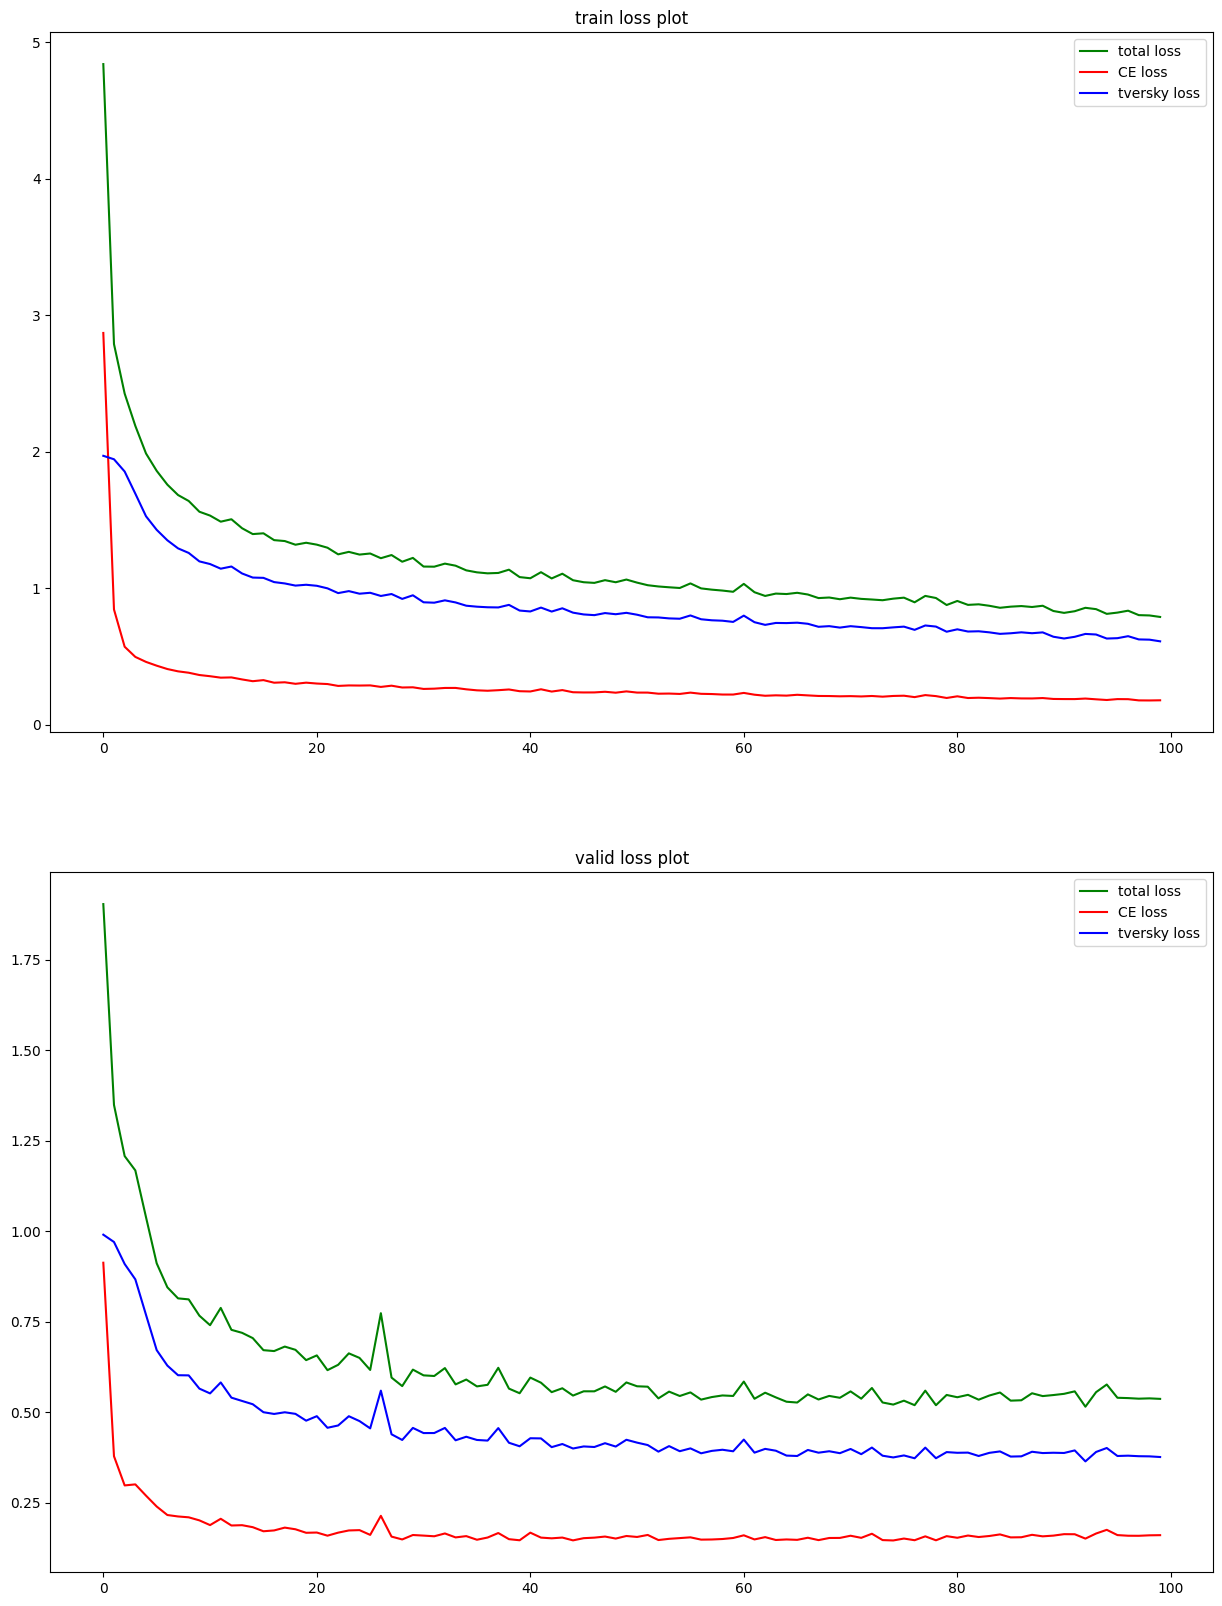

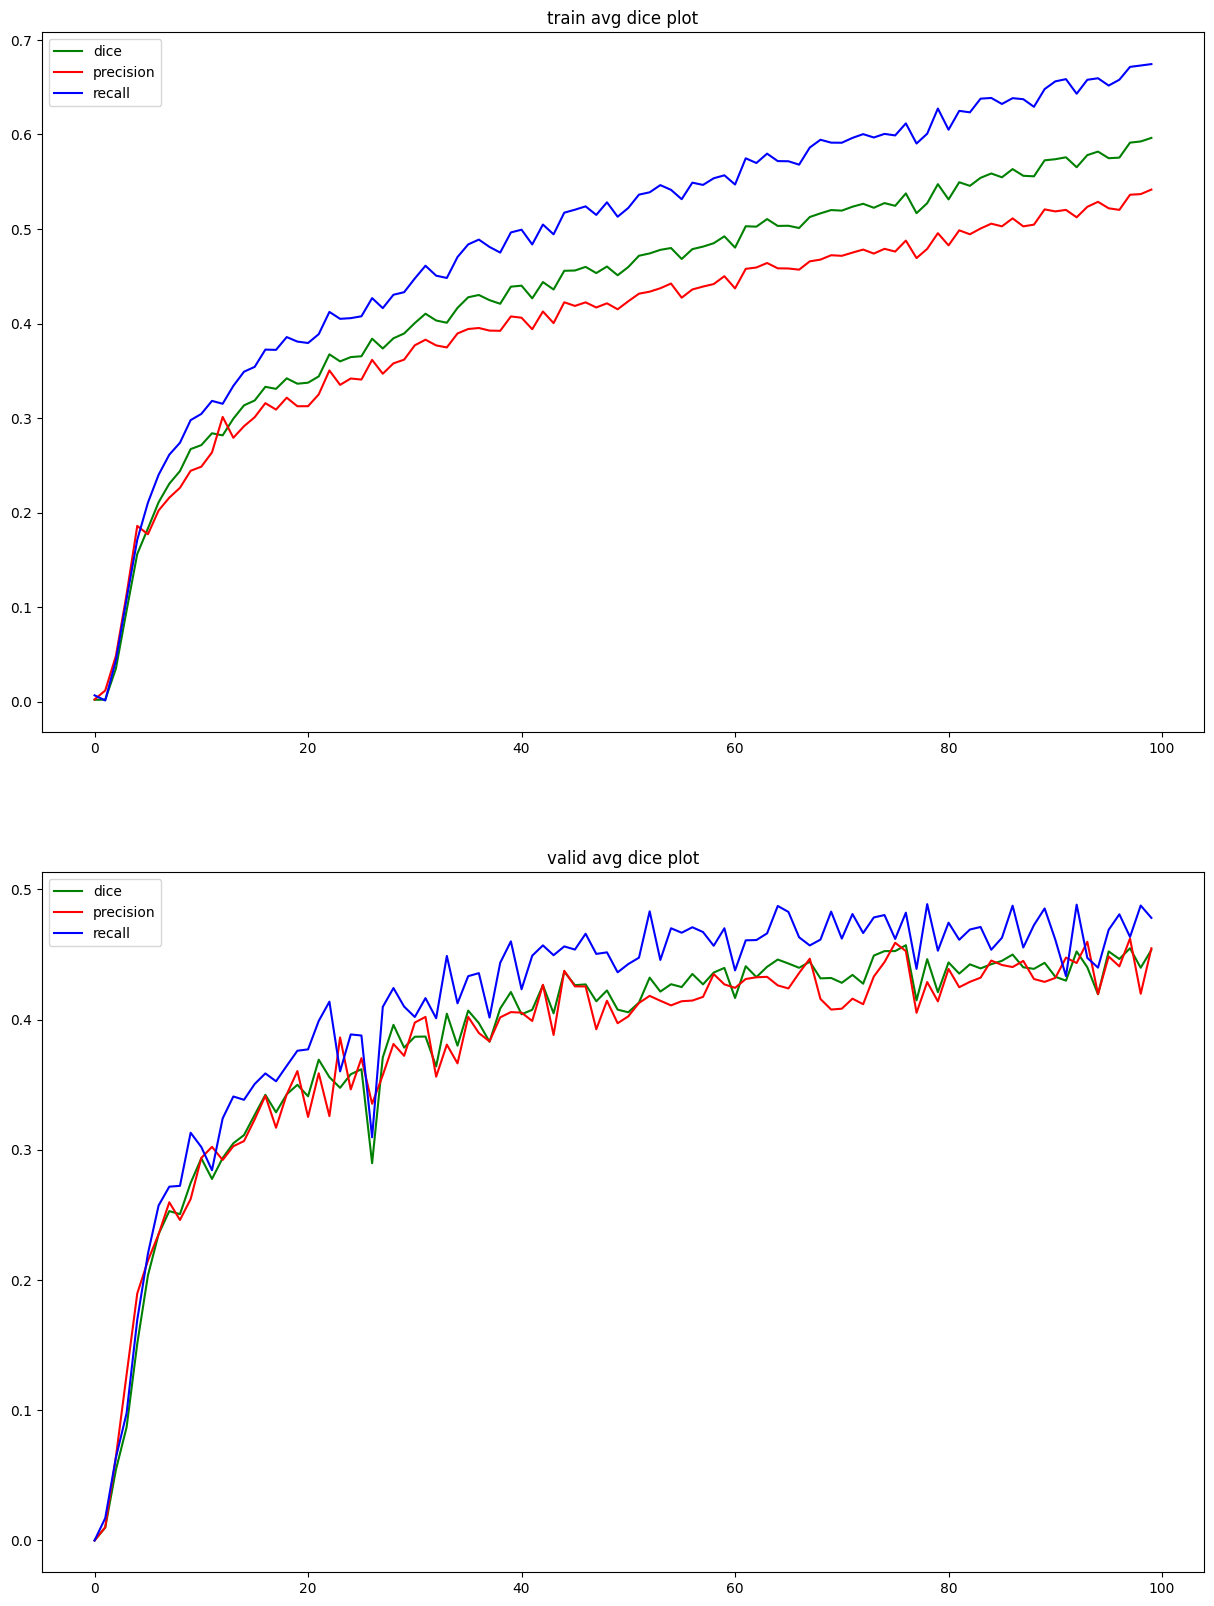

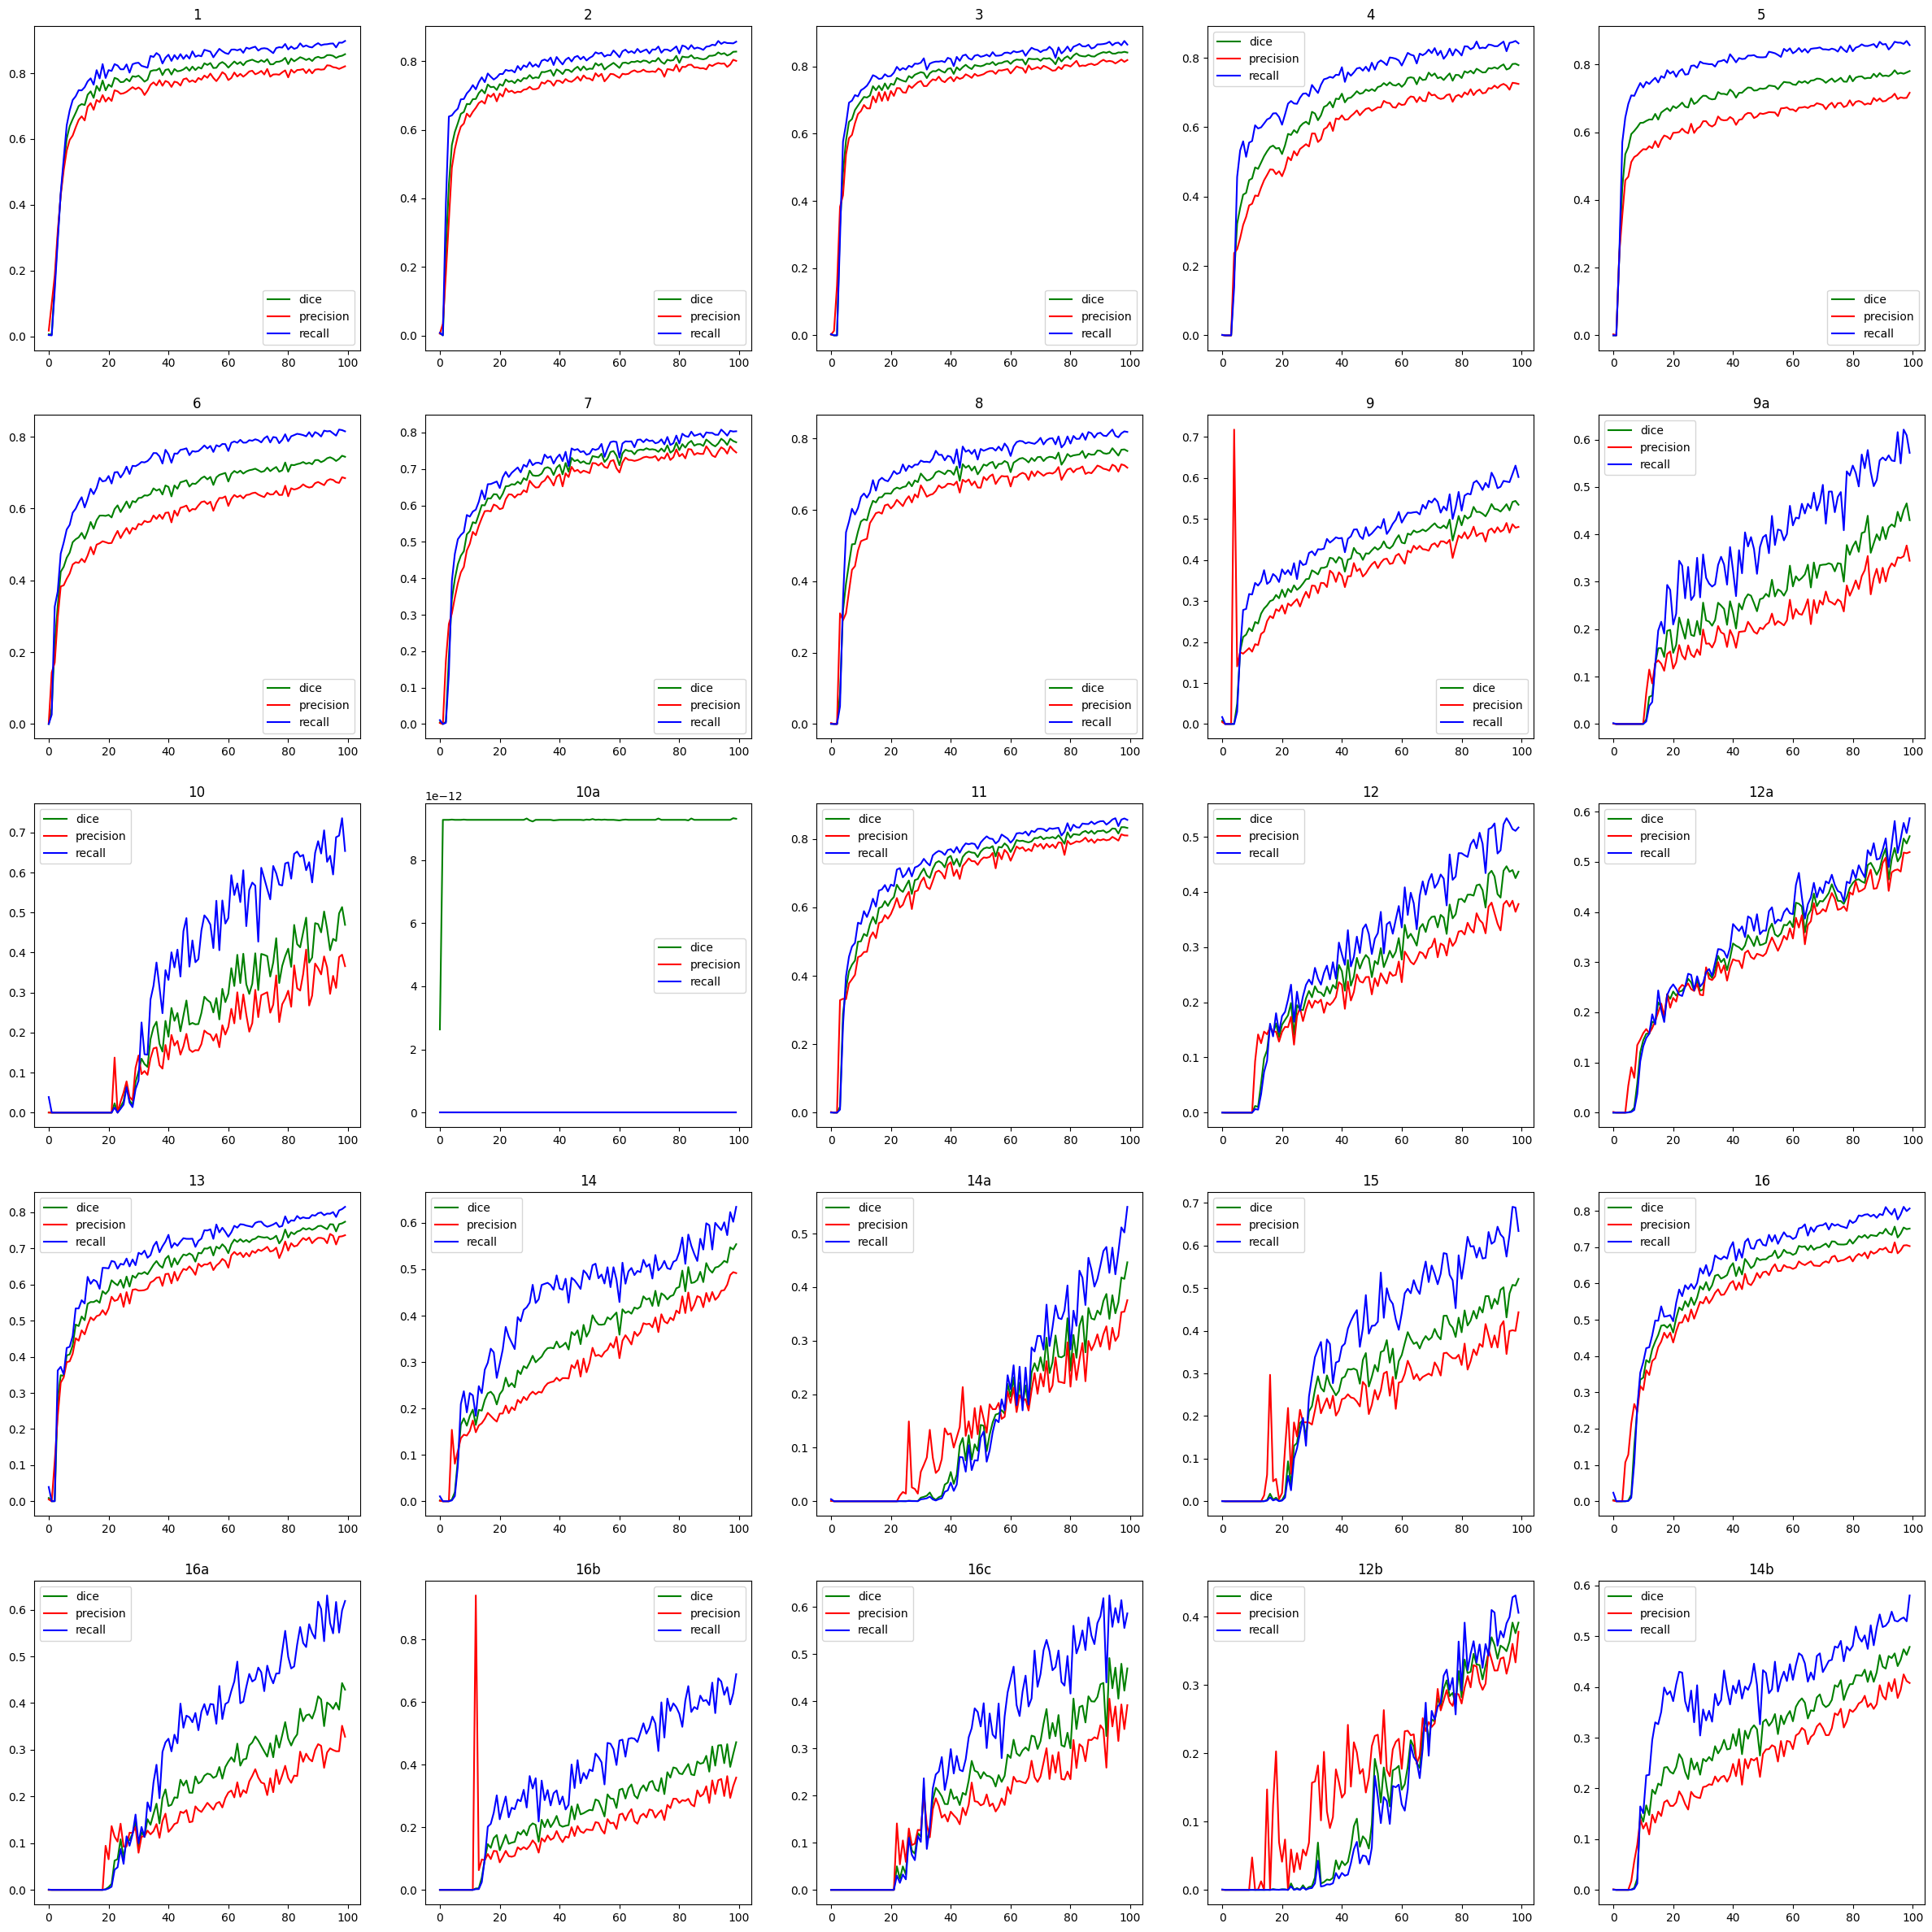

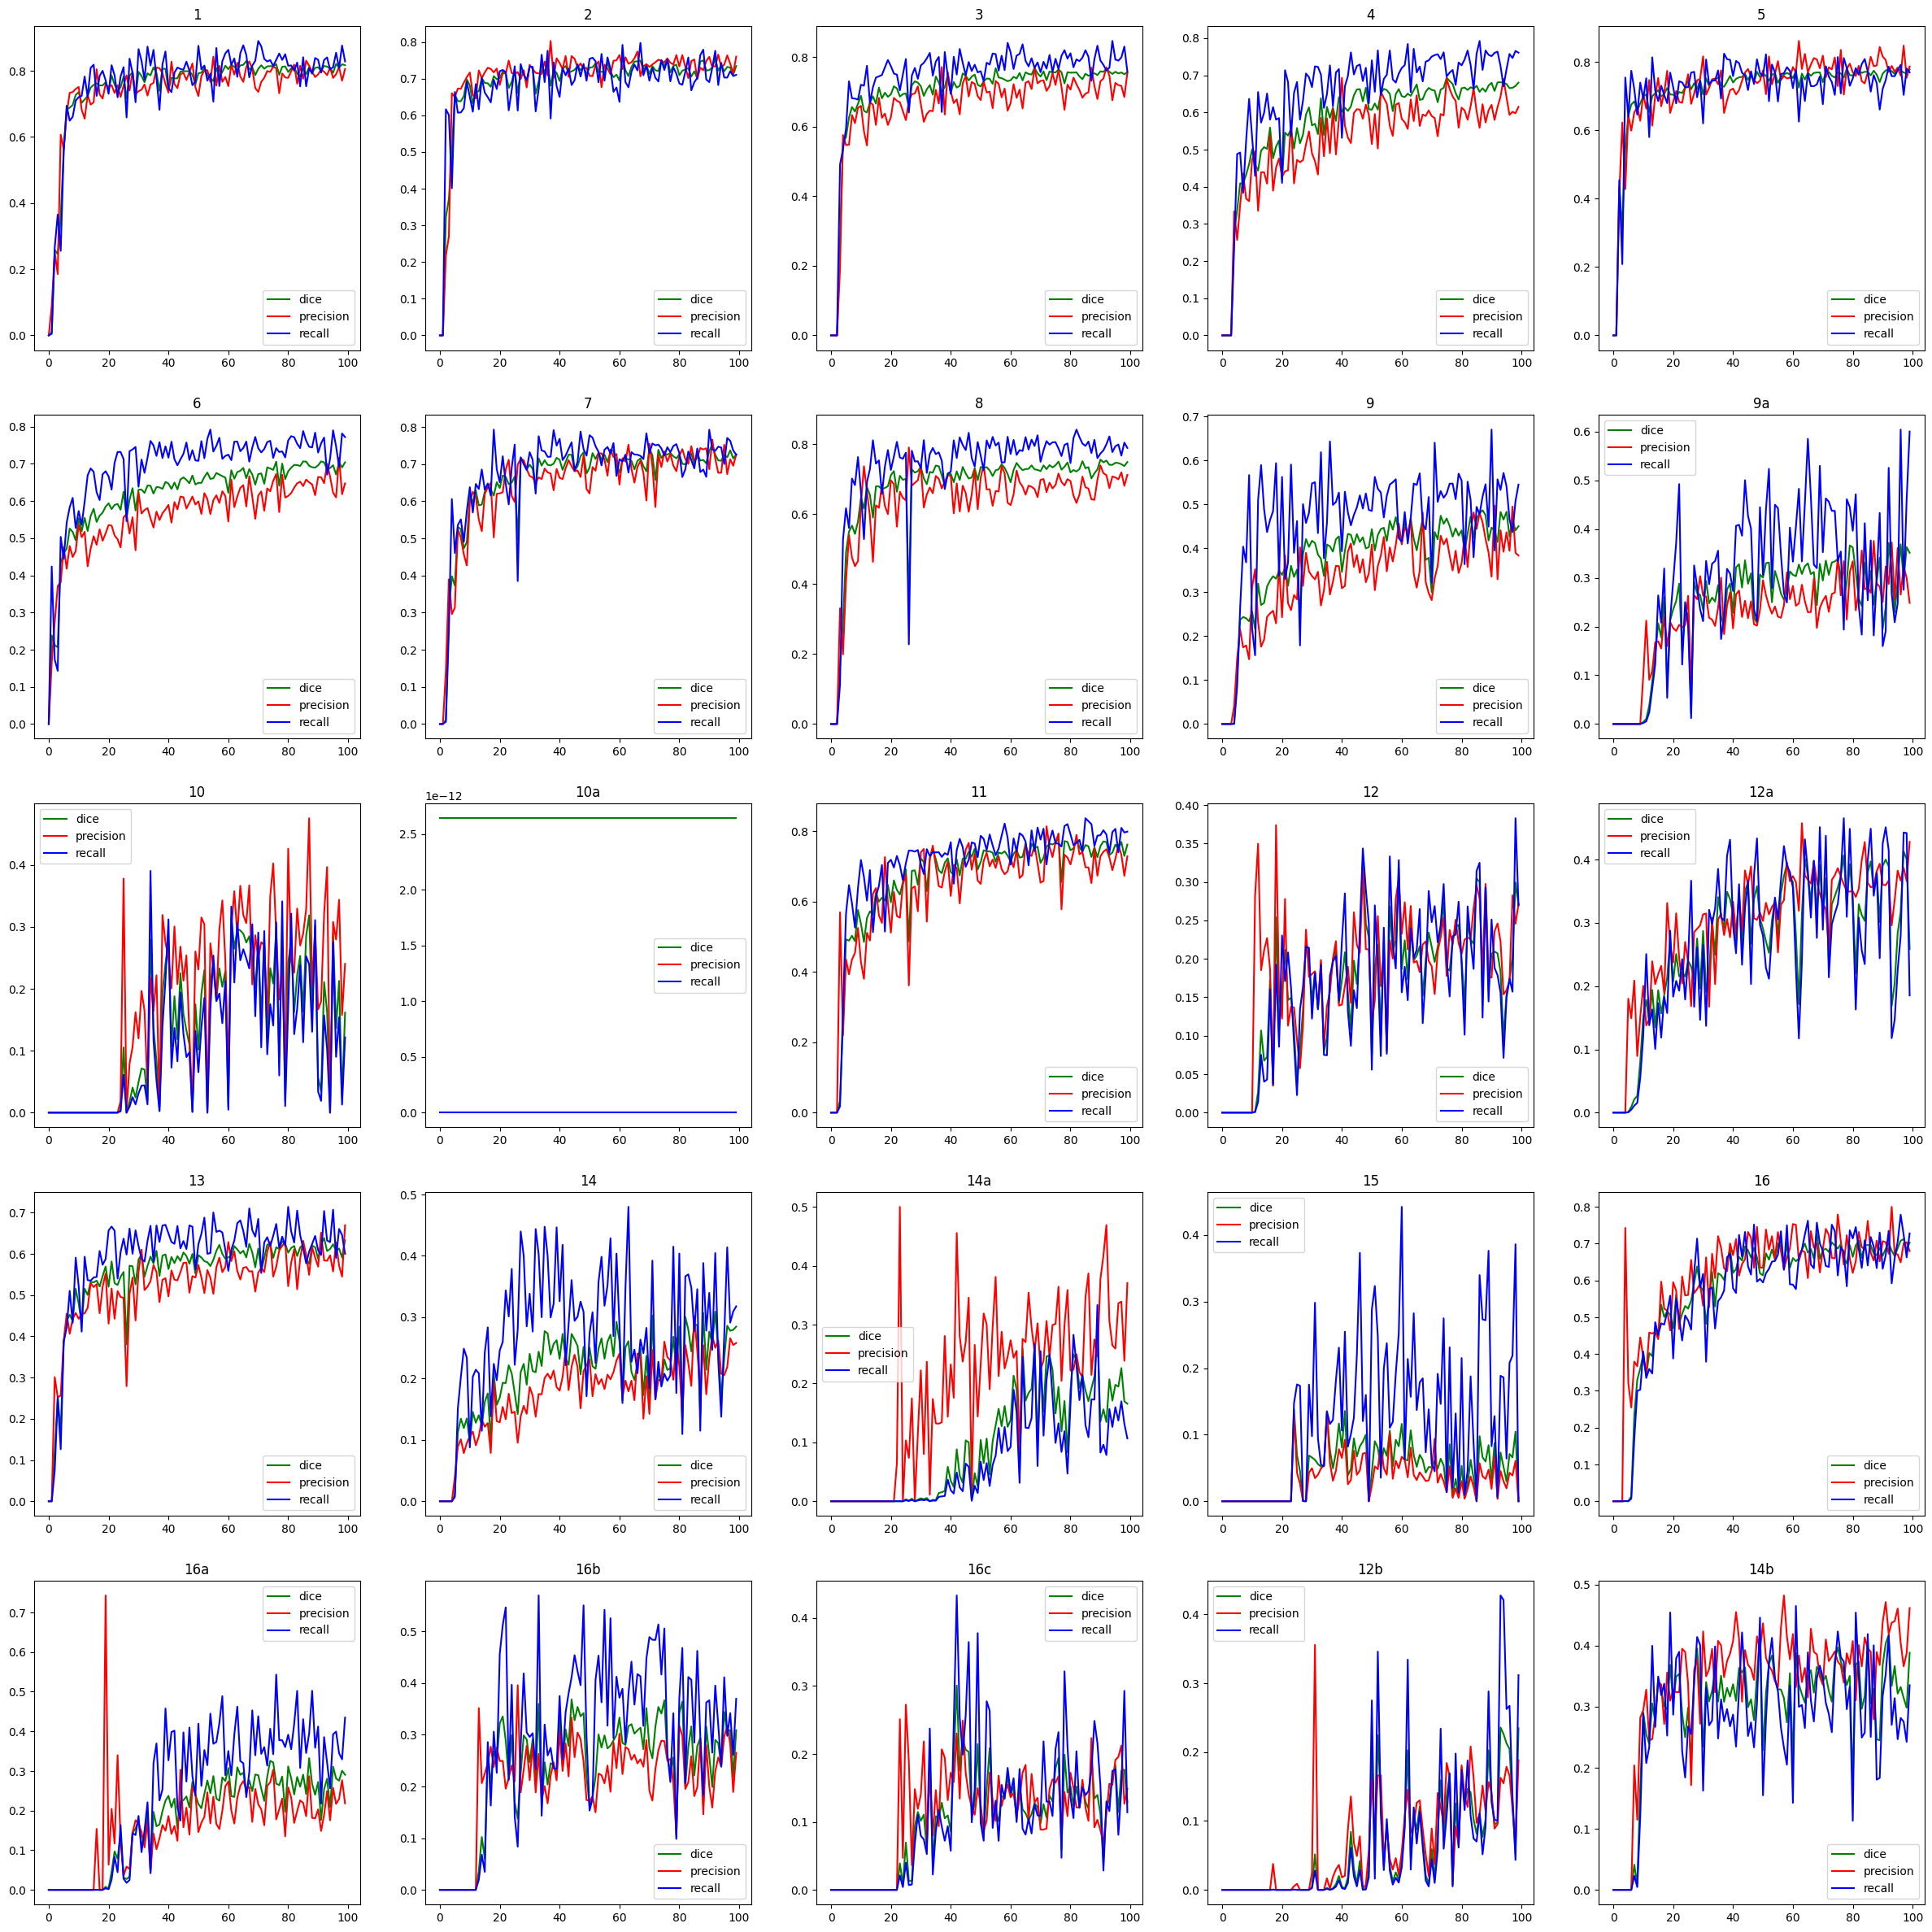

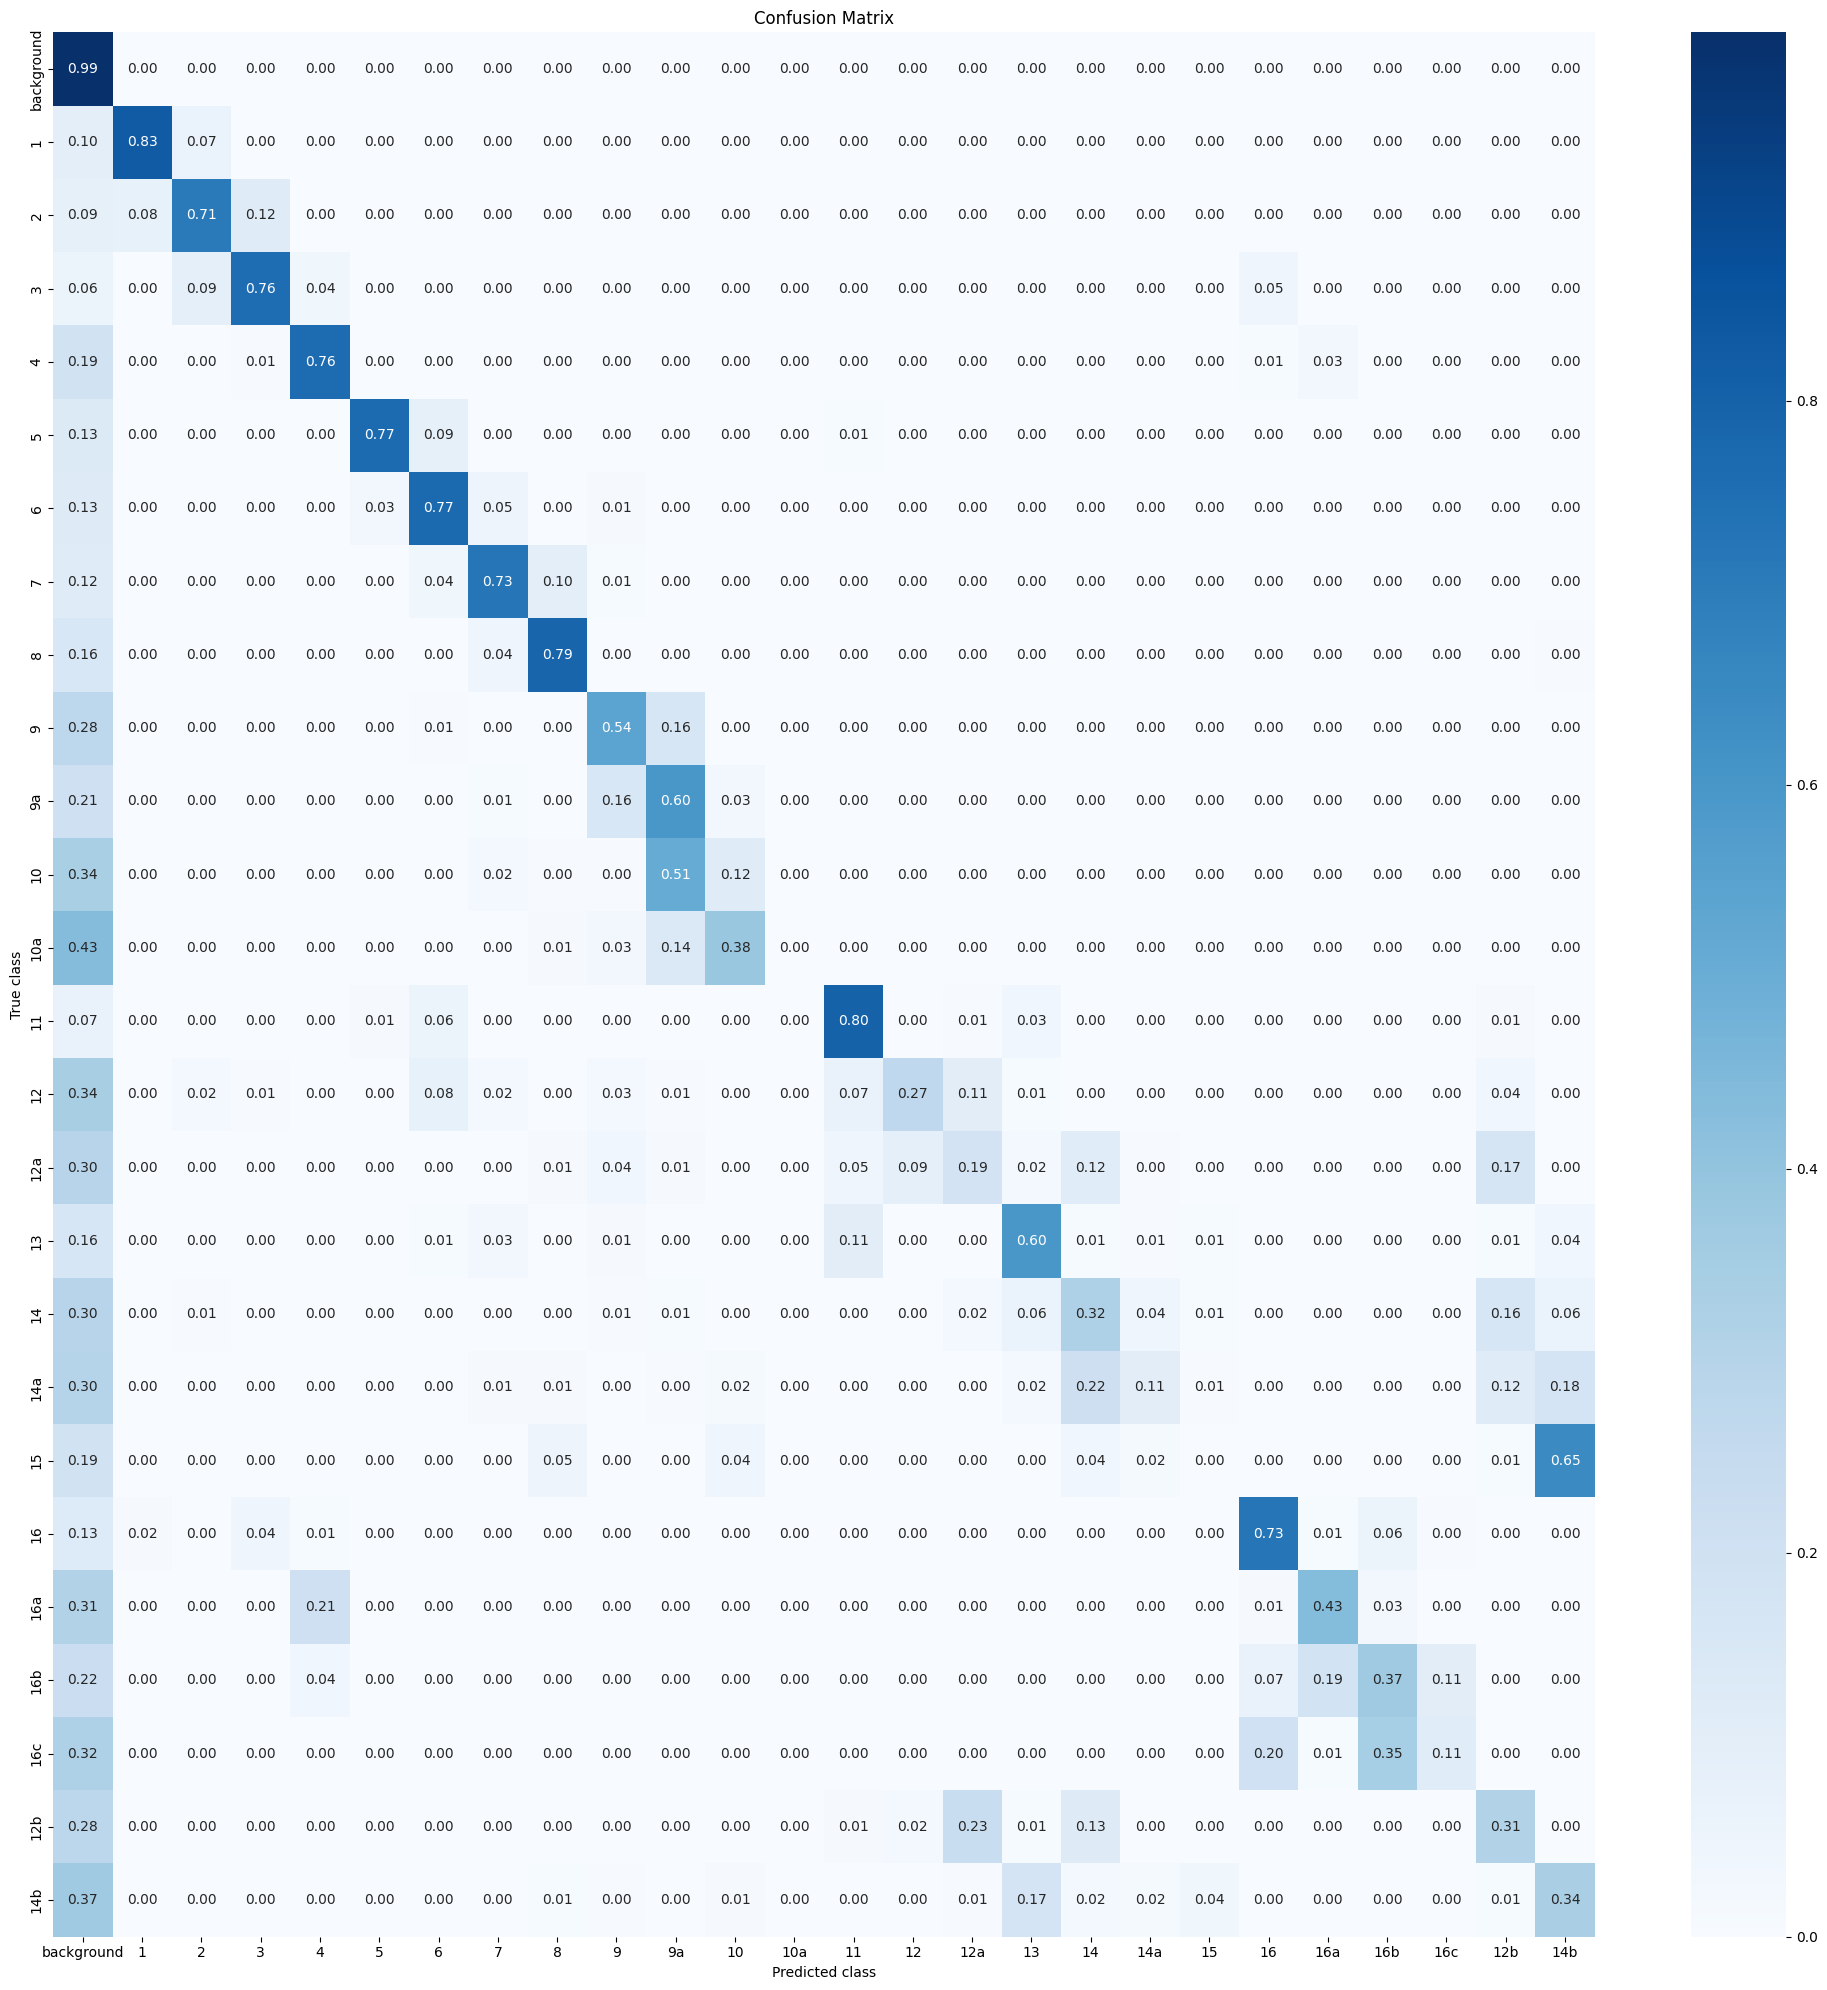

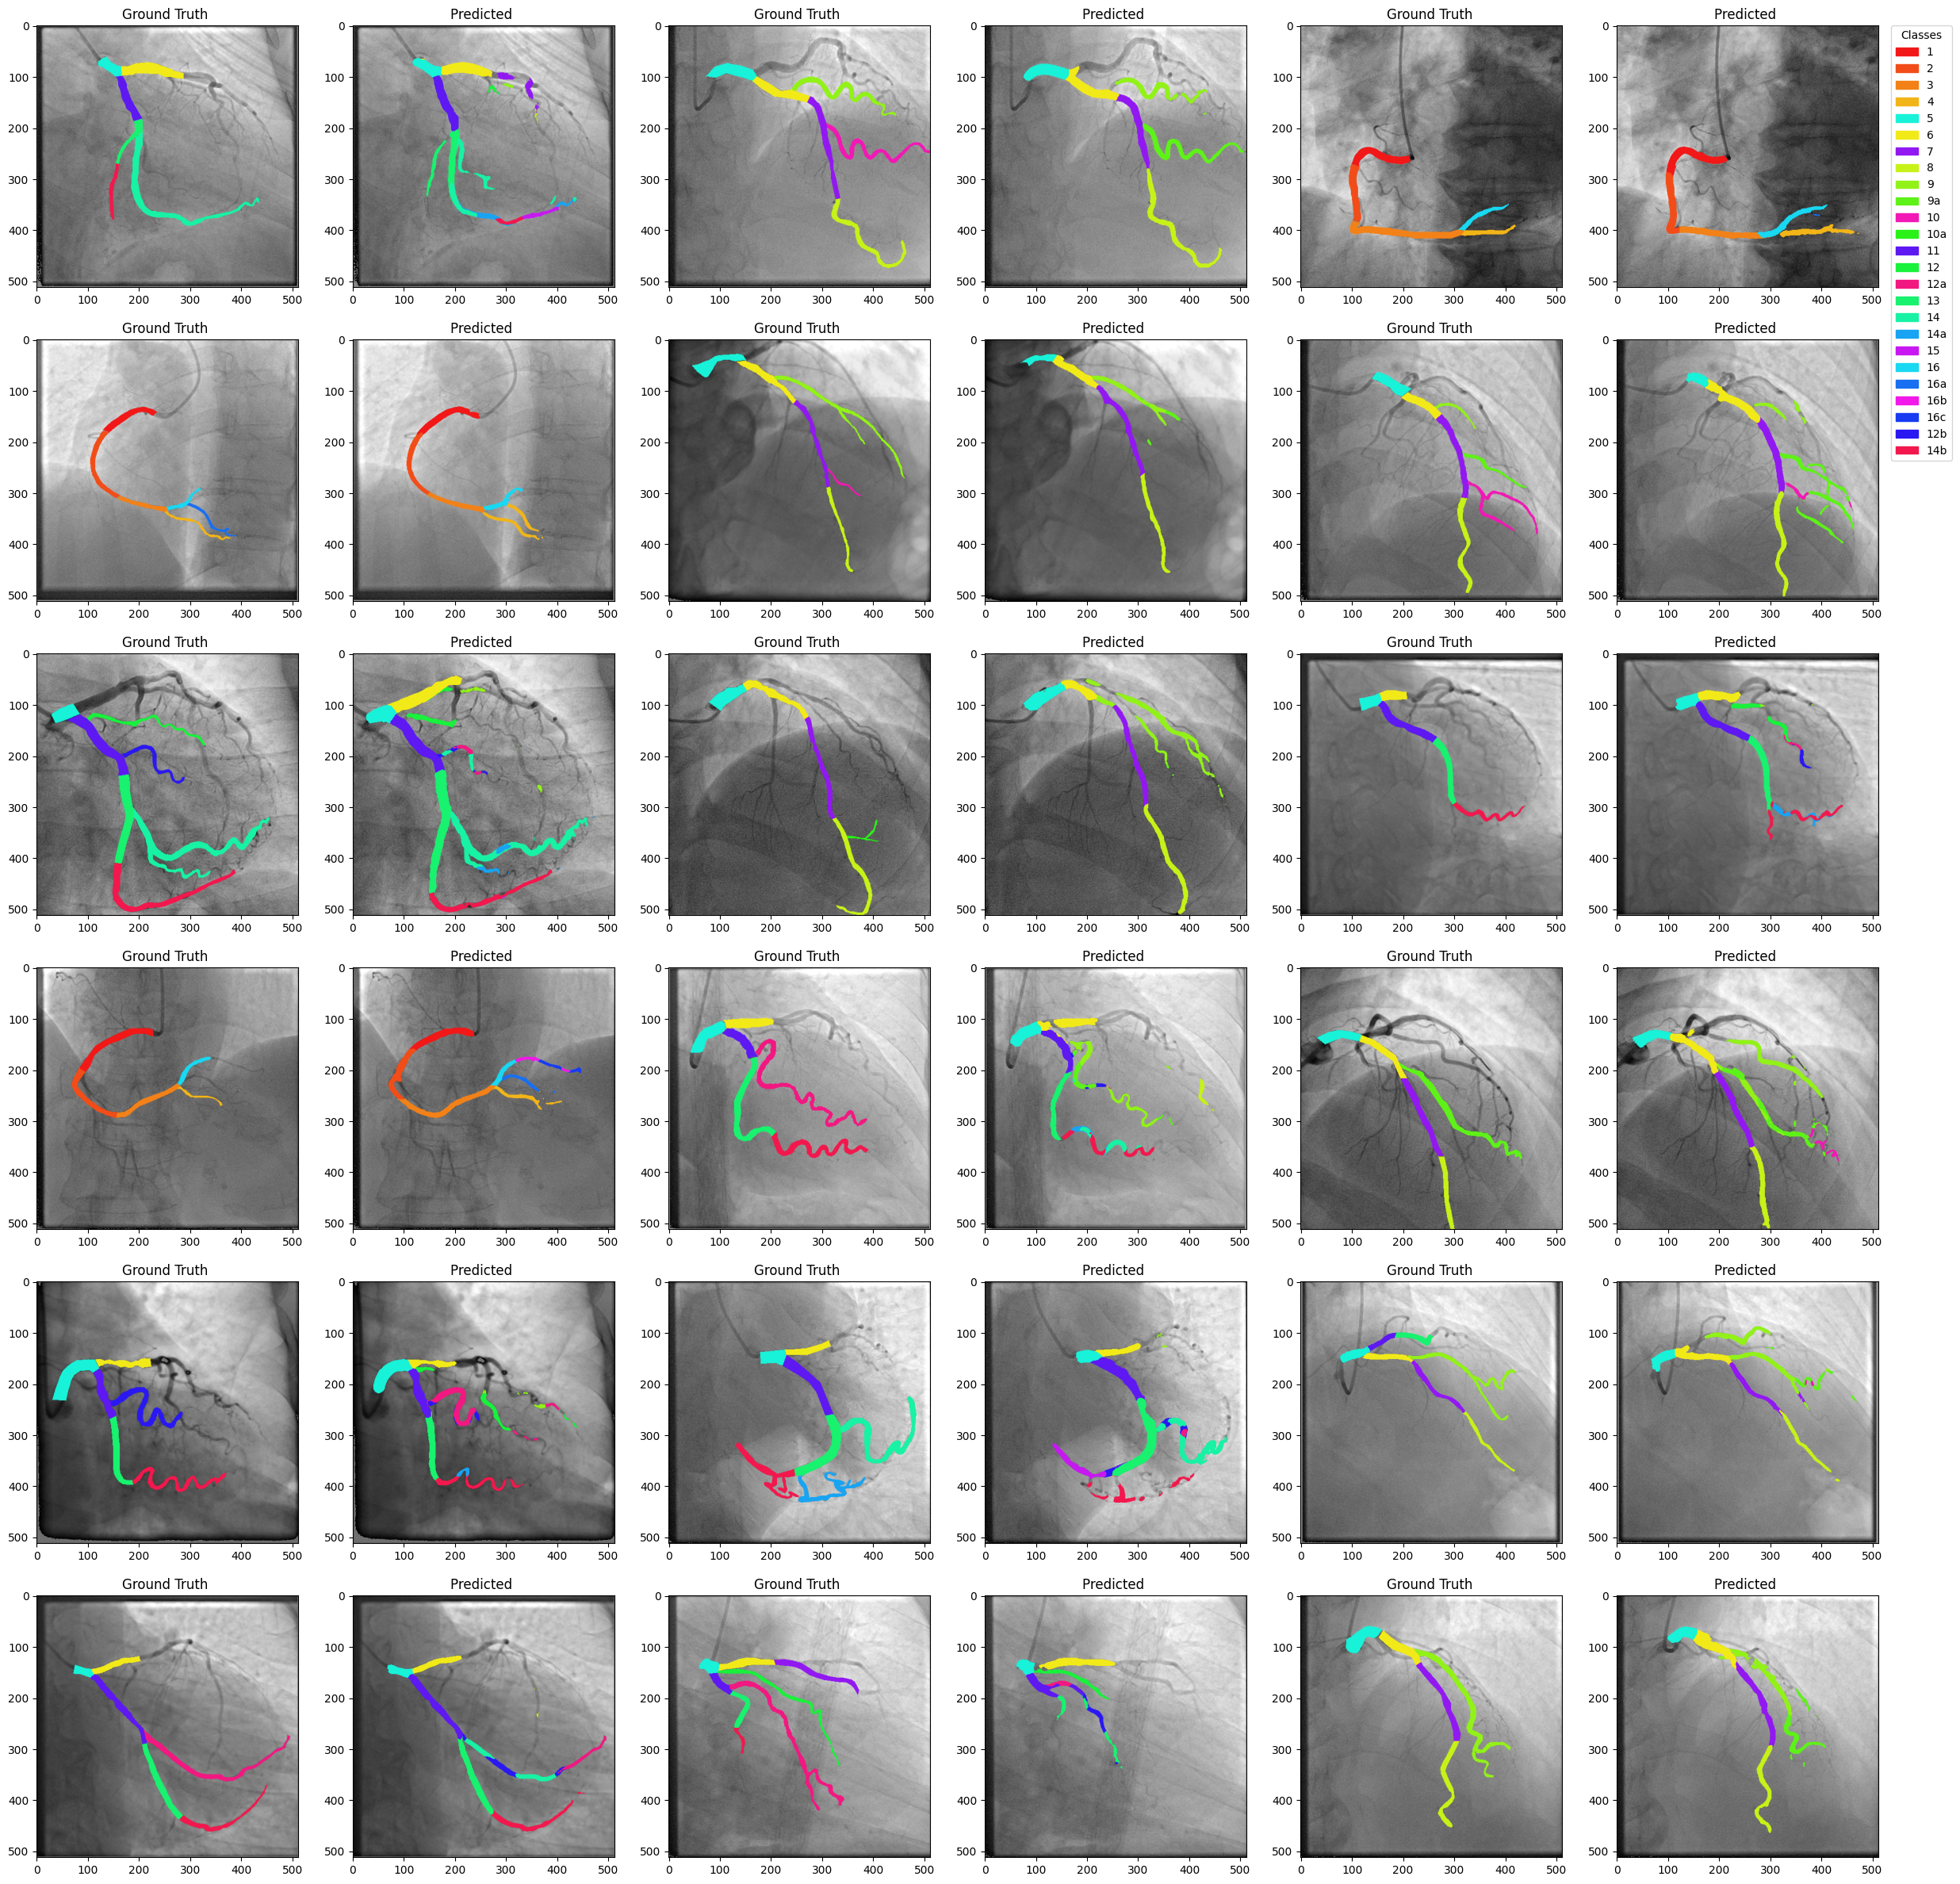

In [11]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)